# Trip Level Analysis

In this notebook we show how to model maximum occupancy at the trip level using the following regression models:

* Poisson
* Negative Binomial
* Zero-Inflated Poisson
* Zero-Inflated Negative Binomial
* Hurdle Model

The following libraries are required to run this notebook:

In [9]:
library(dplyr)
library(tidyr)
library(tidyverse)
library(lubridate)
library(tibble)
library(data.table)
library(MASS)
library(pscl)
library(caret)
library(readr)
library(ggplot2)
library(janitor)
library(rFerns)
library(ordinalForest)
library(RRF)
library(ranger)

While it is not necessary to upload any data in this notebook -since the developed functions called the respective data by using `route_id`, `direction_id`, `trip_id`, and data partition. We upload the data to create some figures for the TRB paper:

In [3]:
carta = read_csv('data/jmartinez/Transit_Data/carta.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  scheduled_arrival_time = col_datetime(format = ""),
  actual_arrival_time = col_datetime(format = ""),
  direction_desc = col_character(),
  service_period = col_character(),
  date = col_date(format = ""),
  scheduled_datetime = col_datetime(format = ""),
  actual_arrival_datetime = col_datetime(format = ""),
  trip_start_time = col_datetime(format = ""),
  trip_date = col_date(format = ""),
  service_kind = col_character()
)
ℹ Use `spec()` for the full column specifications.


Warning message:
“1658648 parsing failures.
    row      col               expected actual                                    file
5820871 route_id no trailing characters    10A 'data/jmartinez/Transit_Data/carta.csv'
5820872 route_id no trailing characters    10A 'data/jmartinez/Transit_Data/carta.csv'
5820873 route_id no trailing characters    10A 'data/jmartinez/Transit_Data/carta.csv'
5820874

In [4]:
carta$trip_id = as.character(carta$trip_id)
carta$stop_id = as.character(carta$stop_id)
carta$route_id = as.character(carta$route_id)
carta$direction_id = as.character(carta$direction_id)
carta$hour = factor(carta$hour)
carta$month = factor(carta$month)

In [90]:
head(carta)

trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,⋯,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dttm>,<dttm>,<dbl>,<date>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
132994,1900-01-01 04:55:00,1900-01-01 04:52:00,1351,1,35.05266,-85.30972,1,0,1,⋯,2019-01-02 04:52:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.350000,0,weekday
132994,1900-01-01 04:55:41,1900-01-01 04:56:00,12,2,35.05070,-85.30953,1,0,0,⋯,2019-01-02 04:56:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.343167,0,weekday
132994,1900-01-01 04:56:20,1900-01-01 04:57:00,1555,3,35.04883,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.336667,0,weekday
132994,1900-01-01 04:56:35,1900-01-01 04:57:00,1579,4,35.04812,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.334167,0,weekday
132994,1900-01-01 04:57:22,1900-01-01 04:57:00,1354,5,35.04598,-85.30952,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.326333,0,weekday
132994,1900-01-01 04:57:35,1900-01-01 04:57:00,1353,6,35.04538,-85.30945,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.324167,0,weekday


In [174]:
setwd('/home/jmartinez')

In [621]:
min(carta$trip_date)

[1] "2019-01-02"

In [7]:
max(carta$trip_date)

[1] "2020-05-31"

The following cell summarizes the overall maximum occupancy per route.

In [105]:
max_occupancy_dt <- carta %>%
  filter(route_id %in%  c('1', '4', '9')) %>%
  group_by(route_id, trip_id) %>%
  mutate(occupancy = if_else(occupancy < 0, 0, occupancy),
         occupancy = if_else(occupancy > 32, 32, occupancy),
         max_occupancy = max(occupancy)) %>%
  summarise(route_id, max_occupancy)

head(max_occupancy_dt)

`summarise()` has grouped output by 'route_id', 'trip_id'. You can override using the `.groups` argument.



route_id,trip_id,max_occupancy
<chr>,<chr>,<dbl>
1,132994,5
1,132994,5
1,132994,5
1,132994,5
1,132994,5
1,132994,5


In [106]:
max_occupancy_dt <- unique(max_occupancy_dt)
head(max_occupancy_dt)


route_id,trip_id,max_occupancy
<chr>,<chr>,<dbl>
1,132994,5
1,132995,3
1,132996,13
1,132997,16
1,132998,5
1,132999,15


The following cell show the histogram of maximum occupancies per route:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



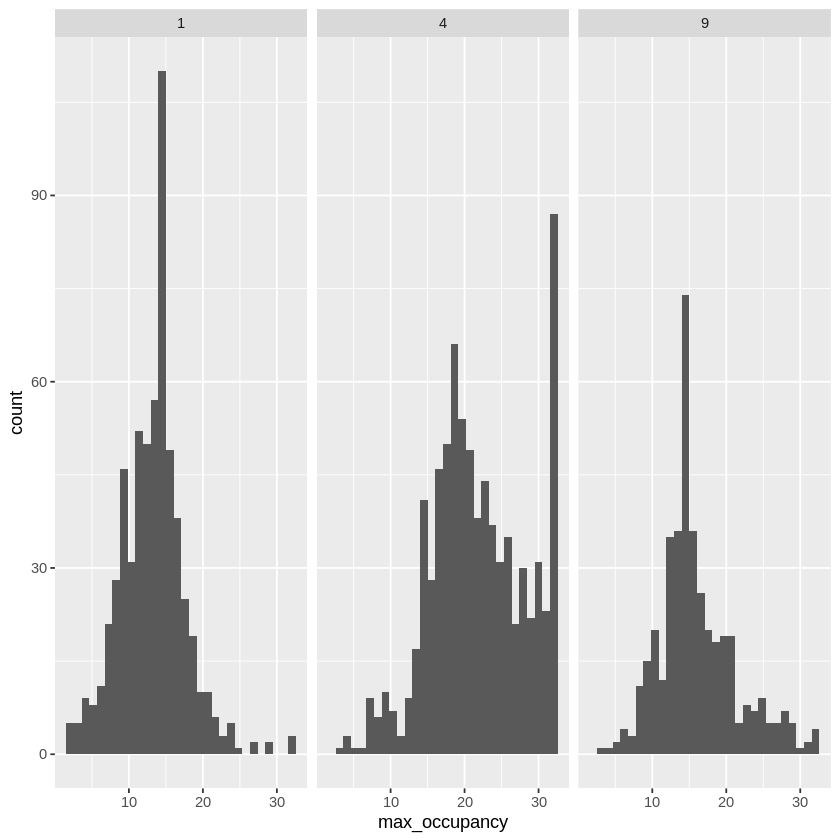

In [103]:

max_occupancy_dt %>%
    group_by(route_id, trip_id) %>%
    ggplot(aes(x = max_occupancy, group = route_id)) +
    geom_histogram() +
    facet_wrap(~route_id)


Since the figure titles can be misleading, we create a new variable called `Route` that has the `route_id` after the word `Route`:

In [143]:
Route = factor(carta$route_id, levels = levels(carta$route_id), labels = paste('Route', levels(carta$route_id), sep = ' '))
Route

[1] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [10] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [19] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [28] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [37] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [46] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [55] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [64] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [73] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [82] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
   [91] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [100] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [109] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [118] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [127] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [136] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [145] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [154] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [163] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [172] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [181] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [190] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [199] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [208] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [217] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [226] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [235] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [244] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [253] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [262] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [271] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [280] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [289] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [298] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [307] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [316] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [325] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [334] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [343] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [352] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [361] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [370] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [379] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [388] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [397] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [406] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [415] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [424] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [433] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [442] Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1 Route 1
  [4

In [142]:
levels(carta$route_id)

[1] "1"  "13" "15" "16" "19" "2"  "21" "28" "3"  "4"  "7"  "8"  "9"

Then, we can create the histogram of maximum occupancies with clear titles or labels:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



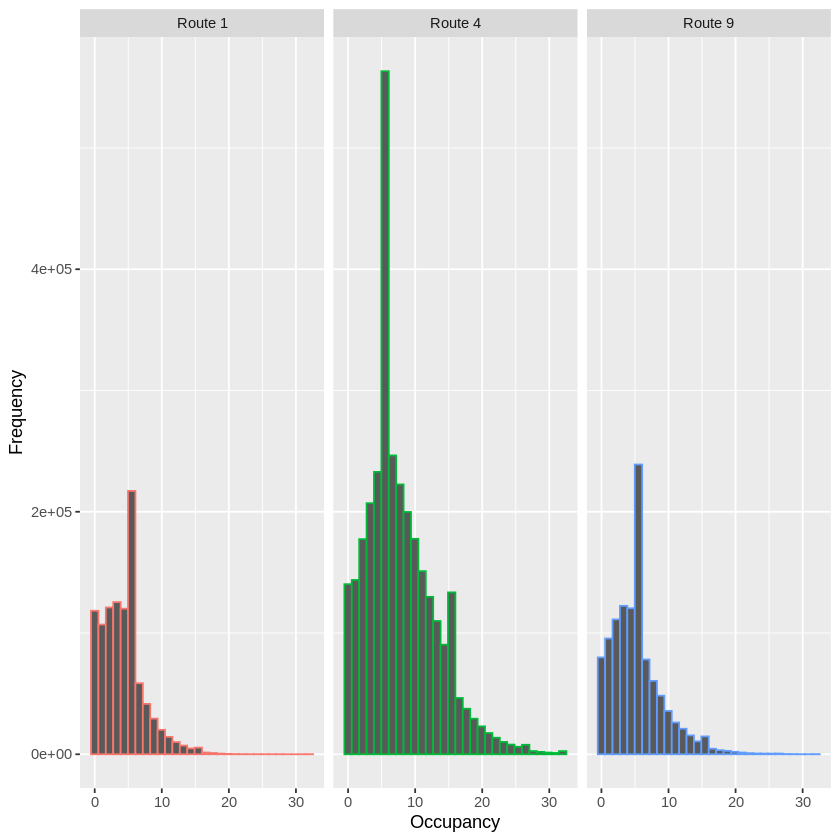

In [146]:
carta %>%
  filter(route_id %in% c('1', '4', '9')) %>%
  mutate(occupancy = if_else(occupancy > 32, 32, occupancy),
         occupancy = if_else(occupancy < 0, 0, occupancy),
         Route = factor(route_id, levels = levels(route_id), labels = paste('Route', levels(route_id), sep = ' '))) %>%
  unique() %>%
  group_by(Route) %>%
  ggplot(aes(x = occupancy, colour = Route, group = Route)) +
  xlab('Occupancy') + ylab('Frequency') +
  geom_histogram()  +
  facet_wrap(~Route) +
  theme(legend.position = 'none')

# Generalized Linear Models

The `all_models_trips_cv()` function trains the proposed models and computes the train and test RMSEs by using a k-fold cross-validation approach. It requires four input values to train a model for each trip:

* `rt == route_id`
* `di == direction_id`
* `part`: `Pre` or `Post`
* `trip == trip_id`

It returns the following:

* `*_DT_train.csv`: Train set.
* `*_DT_test.csv`: Test set
* `*_RMSEs.csv`: Train and test RMSEs.
* `Chart_glm_Predictions.csv`: Test set and their respective model predictions.
* `Poisson_model.rds`: Trained Poisson model.
* `NB_model.rds`: Trained Negative Binomial model. 
* `ZIP_model.rds`: Trained Zero-Inf. Poisson model.
* `ZINB_model.rds`: Trained Zero-Inf. Negative Binomial model.
* `Hurdle_model.rds`: Trained Hurdle Poisson Binomial model.

Finally, notice that when the trip data does not have zero maximum occupancies, only the Poisson and Negative Binomial regression models will be performed.

In [127]:
all_models_trips_cv <- function(rt, di, part, trip){
    
    library(caret)
    library(pscl)
    library(caret)
        
    setwd('/home/jmartinez')
    
    file_dir = paste('data', 'jmartinez', 'Max_Occupancy_Trips', 'data',
                     sep = '/')
    
    file_name = paste0(part, '_', 'Trips', '_', 'r', rt, '_', 'd', di, '.csv')
    
    file_path = paste(file_dir, file_name, sep = '/')
    
    DF = read_csv(file_path)
    
    trip_df <- DF %>%
        filter(trip_id == trip)
    
    num_rows_dt = nrow(trip_df)
    
    if(num_rows_dt == 0){
        return('Insufficient data for analysis!')
    }
    
    else{
        
        trip_df <- unique(trip_df)
  
        num_zeros = dim(trip_df %>% filter(max_occupancy == 0))[1]

        set.seed(123)
        inTraining <-  createDataPartition(trip_df$max_occupancy,
                                           times = 1, p = 0.7,
                                            list = FALSE)
        
        DT_train <- trip_df[inTraining, ]
        DT_test <- trip_df[-inTraining, ]

        num_hours = length(unique(trip_df$hour))

        if(num_hours < 2){

            dt_train = DT_train[ , -c(1:3)]
            dt_test = DT_test[ , -c(1:3)]
        }
        else{

            dt_train = DT_train[, -c(1:2)]
            dt_test = DT_test[, -c(1:2)]
        }

        setwd('data/jmartinez/Max_Occupancy_Trips/Results')
        results_path = paste(paste('route', rt, sep = '_'),
                             paste(part, 'lockdown', sep = '_'),
                             paste('direction', di, sep = ''),
                             sep = '/')

        setwd(results_path)

        dir.create(trip)

        n_row_train = nrow(DT_train)

        if(n_row_train < 50){

            return('Insufficient data for analysis!')
        }
        else if(n_row_train >= 50){
            if(num_zeros ==  0){

                k = 3

                sm_Poiss <- list()
                sm_NB <- list()

                RMSE_Poiss = 0
                RMSE_NB = 0

                k_fold_pred_Poiss <- list()
                k_fold_pred_NB <- list()

                predictions_Poiss = 0
                predictions_NB = 0

                set.seed(123)
                rand_ind = createDataPartition(dt_train$max_occupancy, times = k, p = 0.5)

                for(i in 1:k){

                   df = dt_train[rand_ind[[i]],]
                   df_test = dt_train[-rand_ind[[i]],]  

                   Poiss.fit = glm(max_occupancy ~ ., data = df, family = 'poisson')        
                   NB.fit = glm.nb(max_occupancy ~ ., data = df)

                   k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                   k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")

                   RMSE_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_Poiss[[i]])^{2})) 
                   RMSE_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_NB[[i]])^{2}))

                }

                # Train RMSE

                train_RMSE_poiss = mean(RMSE_Poiss)
                train_RMSE_nb = mean(RMSE_NB)

                # Fit models with training data to calculate test RMSEs:

                model_poiss_train = glm(max_occupancy ~ ., data = dt_train, family = 'poisson')
                model_nb_train = glm.nb(max_occupancy ~ ., data = dt_train)

                #------------------------------------------------------------------------------------------
                # Test predictions:

                predictions_poiss_test = predict(model_poiss_train, dt_test, type = "response")
                predictions_nb_test = predict(model_nb_train, dt_test, type = "response")

                DT_test$Poiss_Predictions = predictions_poiss_test
                DT_test$NB_Predictions = predictions_nb_test

                # Test RMSEs:

                test_RMSE_poiss = sqrt(mean((dt_test$max_occupancy - predictions_poiss_test)^{2}))
                test_RMSE_nb = sqrt(mean((dt_test$max_occupancy - predictions_nb_test)^{2}))

                # Predicitons on all available data:

                RMSEs = data.frame(cbind(
                    rbind('Train' = train_RMSE_poiss, 'Test' = test_RMSE_poiss),
                    rbind('Train' = train_RMSE_nb, 'Test' = test_RMSE_nb)
                ))

                colnames(RMSEs) = c('Poiss_RMSE', 'NB_RMSE')

                file_DT_train_name = paste(trip, paste(part, 'DT_train.csv', sep = '_'), sep = '/')
                file_DT_test_name = paste(trip, paste(part, 'DT_test.csv', sep = '_'), sep = '/')

                file_name_RMSEs = paste(trip, paste(part, 'RMSEs.csv', sep = '_'), sep = '/')
                file_name_Predictions = paste(trip, paste(part, 'Chart_glm_Predictions.csv', sep = '_'), sep = '/')

                final_poiss_model = paste(trip, paste(part, 'Poisson_model.rds', sep = '_'), sep = '/')
                final_nb_model = paste(trip, paste(part, 'NB_model.rds', sep = '_'), sep = '/')

                write.csv(RMSEs, file_name_RMSEs)
                write.csv(DT_test, file_name_Predictions, row.names = F)

                write.csv(DT_train, file_DT_train_name, row.names = F)
                write.csv(DT_test, file_DT_test_name, row.names = F)

                saveRDS(model_poiss_train, final_poiss_model)
                saveRDS(model_nb_train, final_nb_model)

           }
           else if((num_zeros >= 1) & (num_zeros <= 5)){


               zeros <- which(trip_df$max_occupancy == 0, arr.ind = T)

               k = max(1, num_zeros-2)

               sm_Poiss <- list()
               sm_NB <- list()
               sm_ZI_Poiss <- list()
               sm_ZI_NB <- list()
               sm_hurdle <- list()

               RMSE_Poiss = 0
               RMSE_NB = 0
               RMSE_ZI_Poiss = 0
               RMSE_ZI_NB = 0
               RMSE_hurdle = 0

               k_fold_pred_Poiss <- list()
               k_fold_pred_NB <- list()
               k_fold_pred_ZI_Poiss <- list()
               k_fold_pred_ZI_NB <- list()
               k_fold_pred_hurdle <- list()

               predictions_Poiss = 0
               predictions_NB = 0
               predictions_ZI_Poiss = 0
               predictions_ZI_NB = 0
               predictions_hurdle = 0

               set.seed(123)
               rand_ind = createDataPartition(dt_train$max_occupancy, times = k, p = 0.75) 

               for(i in 1:k){

                   df = dt_train[rand_ind[[i]],]
                   df_test = dt_train[-rand_ind[[i]],]

                   cv_train_zeros = which(df$max_occupancy == 0, arr.ind = T)
                   cv_test_zeros = which(df_test$max_occupancy == 0, arr.ind = T)

                   if(length(cv_train_zeros) <= length(cv_test_zeros)){

                       df[(nrow(df) + 1), ] = df_test[cv_test_zeros[1],]
                       df_test = df_test[-cv_test_zeros[1],]

                       Poiss.fit = glm(max_occupancy ~ ., data = df, family = 'poisson')        
                       NB.fit = glm.nb(max_occupancy ~ ., data = df)
                       ZI.Poiss = zeroinfl(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson', link = 'logit')          
                       ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                        data = df, dist = 'negbin', link = 'logit')          
                       hurdle.fit = hurdle(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson',
                                           zero.dist = 'binomial', link = 'logit')

                       k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                       k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                       k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                       k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                       k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")

                       RMSE_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_Poiss[[i]])^{2})) 
                       RMSE_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_NB[[i]])^{2}))
                       RMSE_ZI_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_Poiss[[i]])^{2}))
                       RMSE_ZI_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_NB[[i]])^{2}))
                       RMSE_hurdle[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_hurdle[[i]])^{2}))

                   }
                   else if(length(cv_train_zeros) > length(cv_test_zeros)){

                       Poiss.fit = glm(max_occupancy ~ ., data = df, family = 'poisson')        
                       NB.fit = glm.nb(max_occupancy ~ ., data = df)
                       ZI.Poiss = zeroinfl(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson', link = 'logit')          
                       ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                        data = df, dist = 'negbin', link = 'logit')          
                       hurdle.fit = hurdle(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson',
                                           zero.dist = 'binomial', link = 'logit')

                       k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                       k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                       k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                       k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                       k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")

                       RMSE_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_Poiss[[i]])^{2})) 
                       RMSE_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_NB[[i]])^{2}))
                       RMSE_ZI_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_Poiss[[i]])^{2}))
                       RMSE_ZI_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_NB[[i]])^{2}))
                       RMSE_hurdle[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_hurdle[[i]])^{2}))
                   }
               }

               # Train RMSE

               train_RMSE_poiss = mean(RMSE_Poiss)
               train_RMSE_nb = mean(RMSE_NB)
               train_RMSE_zip = mean(RMSE_ZI_Poiss)
               train_RMSE_zinb = mean(RMSE_ZI_NB)
               train_RMSE_hurdle = mean(RMSE_hurdle)

               # Fit models with training data to calculate test RMSEs:

               model_poiss_train = glm(max_occupancy ~ ., data = dt_train, family = 'poisson')
               model_nb_train = glm.nb(max_occupancy ~ ., data = dt_train)
               model_zip_train = zeroinfl(max_occupancy ~ . | .,
                                          data = dt_train, dist = 'poisson', link = 'logit')
               model_zinb_train = ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                                   data = dt_train, dist = 'negbin', link = 'logit')
               model_hurdle_train =  hurdle(max_occupancy ~ . | .,
                                            data = dt_train, dist = 'poisson', zero.dist = 'binomial', link = 'logit')

               #------------------------------------------------------------------------------------------
               # Test predictions:

               predictions_poiss_test = predict(model_poiss_train, DT_test, type = "response")
               predictions_nb_test = predict(model_nb_train, DT_test, type = "response")
               predictions_zip_test = predict(model_zip_train, DT_test, type = "response")
               predictions_zinb_test = predict(model_zinb_train, DT_test, type = "response")
               predictions_hurdle_test = predict(model_hurdle_train, DT_test, type = "response")

               DT_test$Poiss_Predictions = predictions_poiss_test
               DT_test$NB_Predictions = predictions_nb_test
               DT_test$ZIP_Predictions = predictions_zip_test
               DT_test$ZINB_Predictions = predictions_zinb_test
               DT_test$Hurdle_Predictions = predictions_hurdle_test

               # Test RMSEs:

               test_RMSE_poiss = sqrt(mean((DT_test$max_occupancy - predictions_poiss_test)^{2}))
               test_RMSE_nb = sqrt(mean((DT_test$max_occupancy - predictions_nb_test)^{2}))
               test_RMSE_zip = sqrt(mean((DT_test$max_occupancy - predictions_zip_test)^{2}))
               test_RMSE_zinb = sqrt(mean((DT_test$max_occupancy - predictions_zinb_test)^{2}))
               test_RMSE_hurdle = sqrt(mean((DT_test$max_occupancy - predictions_hurdle_test)^{2}))

               # Predicitons on all available data:

               RMSEs = data.frame(cbind(
                   rbind('Train' = train_RMSE_poiss, 'Test' = test_RMSE_poiss),
                   rbind('Train' = train_RMSE_nb, 'Test' = test_RMSE_nb),
                   rbind('Train' = train_RMSE_zip, 'Test' = test_RMSE_zip),
                   rbind('Train' = train_RMSE_zinb, 'Test' = test_RMSE_zinb),
                   rbind('Train' = train_RMSE_hurdle, 'Test' = test_RMSE_hurdle)
               ))

               colnames(RMSEs) = c('Poiss_RMSE', 'NB_RMSE', 'ZIP_RMSE', 'ZINB_RMSE', 'Hurdle_RMSE')

               file_DT_train_name = paste(trip, paste(part, 'DT_train.csv', sep = '_'), sep = '/')
               file_DT_test_name = paste(trip, paste(part, 'DT_test.csv', sep = '_'), sep = '/')

               file_name_RMSEs = paste(trip, paste(part, 'RMSEs.csv', sep = '_'), sep = '/')
               file_name_Predictions = paste(trip, paste(part, 'Chart_glm_Predictions.csv', sep = '_'), sep = '/')

               final_poiss_model = paste(trip, paste(part, 'Poisson_model.rds', sep = '_'), sep = '/')
               final_nb_model = paste(trip, paste(part, 'NB_model.rds', sep = '_'), sep = '/')
               final_zip_model = paste(trip, paste(part, 'ZIP_model.rds', sep = '_'), sep = '/')
               final_zinb_model = paste(trip, paste(part, 'ZINB_model.rds', sep = '_'), sep = '/')
               final_hurdle_model = paste(trip, paste(part, 'Hurdle_model.rds', sep = '_'), sep = '/')

               write.csv(RMSEs, file_name_RMSEs)
               write.csv(DT_test, file_name_Predictions, row.names = F)

               write.csv(DT_train, file_DT_train_name, row.names = F)
               write.csv(DT_test, file_DT_test_name, row.names = F)

               saveRDS(model_poiss_train, final_poiss_model)
               saveRDS(model_nb_train, final_nb_model)
               saveRDS(model_zip_train, final_zip_model)
               saveRDS(model_zinb_train, final_zinb_model)
               saveRDS(model_hurdle_train, final_hurdle_model)

           }
           else if(num_zeros > 5){

               zeros <- which(trip_df$max_occupancy == 0, arr.ind = T)

               k = 5

               sm_Poiss <- list()
               sm_NB <- list()
               sm_ZI_Poiss <- list()
               sm_ZI_NB <- list()
               sm_hurdle <- list()

               RMSE_Poiss = 0
               RMSE_NB = 0
               RMSE_ZI_Poiss = 0
               RMSE_ZI_NB = 0
               RMSE_hurdle = 0

               k_fold_pred_Poiss <- list()
               k_fold_pred_NB <- list()
               k_fold_pred_ZI_Poiss <- list()
               k_fold_pred_ZI_NB <- list()
               k_fold_pred_hurdle <- list()

               predictions_Poiss = 0
               predictions_NB = 0
               predictions_ZI_Poiss = 0
               predictions_ZI_NB = 0
               predictions_hurdle = 0

               set.seed(123)
               rand_ind = createDataPartition(DT_train$max_occupancy, times = k, p = 0.5)

               for(i in 1:k){

                   df = dt_train[rand_ind[[i]],]
                   df_test = dt_train[-rand_ind[[i]],]

                   cv_train_zeros = which(df$max_occupancy == 0, arr.ind = T)
                   cv_test_zeros = which(df_test$max_occupancy == 0, arr.ind = T)

                   if((length(cv_train_zeros) == 0) & (length(cv_test_zeros) > 0)){

                       df[(nrow(df) + 1), ] = df_test[cv_test_zeros[1],]
                       df_test = df_test[-cv_test_zeros[1],]

                       Poiss.fit = glm(max_occupancy ~ ., data = df, family = 'poisson')        
                       NB.fit = glm.nb(max_occupancy ~ ., data = df)
                       ZI.Poiss = zeroinfl(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson', link = 'logit')          
                       ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                        data = df, dist = 'negbin', link = 'logit')          
                       hurdle.fit = hurdle(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson',
                                           zero.dist = 'binomial', link = 'logit')

                       k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                       k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                       k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                       k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                       k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")

                       RMSE_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_Poiss[[i]])^{2})) 
                       RMSE_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_NB[[i]])^{2}))
                       RMSE_ZI_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_Poiss[[i]])^{2}))
                       RMSE_ZI_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_NB[[i]])^{2}))
                       RMSE_hurdle[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_hurdle[[i]])^{2}))

                   }
                   else if(length(cv_train_zeros) > length(cv_test_zeros)){

                       Poiss.fit = glm(max_occupancy ~ ., data = df, family = 'poisson')        
                       NB.fit = glm.nb(max_occupancy ~ ., data = df)
                       ZI.Poiss = zeroinfl(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson', link = 'logit')          
                       ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                        data = df, dist = 'negbin', link = 'logit')          
                       hurdle.fit = hurdle(max_occupancy ~ . | .,
                                           data = df, dist = 'poisson',
                                           zero.dist = 'binomial', link = 'logit')

                       k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                       k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                       k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                       k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                       k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")

                       RMSE_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_Poiss[[i]])^{2})) 
                       RMSE_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_NB[[i]])^{2}))
                       RMSE_ZI_Poiss[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_Poiss[[i]])^{2}))
                       RMSE_ZI_NB[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_ZI_NB[[i]])^{2}))
                       RMSE_hurdle[i] = sqrt(mean((df_test$max_occupancy - k_fold_pred_hurdle[[i]])^{2}))
                   }
               }

               # Train RMSE

               train_RMSE_poiss = mean(RMSE_Poiss)
               train_RMSE_nb = mean(RMSE_NB)
               train_RMSE_zip = mean(RMSE_ZI_Poiss)
               train_RMSE_zinb = mean(RMSE_ZI_NB)
               train_RMSE_hurdle = mean(RMSE_hurdle)

               # Fit models with training data to calculate test RMSEs:

               model_poiss_train = glm(max_occupancy ~ ., data = dt_train, family = 'poisson')
               model_nb_train = glm.nb(max_occupancy ~ ., data = dt_train)
               model_zip_train = zeroinfl(max_occupancy ~ . | .,
                                          data = dt_train, dist = 'poisson', link = 'logit')
               model_zinb_train = ZI.NB = zeroinfl(max_occupancy ~ . | .,
                                                   data = dt_train, dist = 'negbin', link = 'logit')
               model_hurdle_train =  hurdle(max_occupancy ~ . | .,
                                            data = dt_train, dist = 'poisson', zero.dist = 'binomial', link = 'logit')

               #------------------------------------------------------------------------------------------
               # Test predictions:

               predictions_poiss_test = predict(model_poiss_train, dt_test, type = "response")
               predictions_nb_test = predict(model_nb_train, dt_test, type = "response")
               predictions_zip_test = predict(model_zip_train, dt_test, type = "response")
               predictions_zinb_test = predict(model_zinb_train, dt_test, type = "response")
               predictions_hurdle_test = predict(model_hurdle_train, dt_test, type = "response")

               DT_test$Poiss_Predictions = predictions_poiss_test
               DT_test$NB_Predictions = predictions_nb_test
               DT_test$ZIP_Predictions = predictions_zip_test
               DT_test$ZINB_Predictions = predictions_zinb_test
               DT_test$Hurdle_Predictions = predictions_hurdle_test

               # Test RMSEs:

               test_RMSE_poiss = sqrt(mean((dt_test$max_occupancy - predictions_poiss_test)^{2}))
               test_RMSE_nb = sqrt(mean((dt_test$max_occupancy - predictions_nb_test)^{2}))
               test_RMSE_zip = sqrt(mean((dt_test$max_occupancy - predictions_zip_test)^{2}))
               test_RMSE_zinb = sqrt(mean((dt_test$max_occupancy - predictions_zinb_test)^{2}))
               test_RMSE_hurdle = sqrt(mean((dt_test$max_occupancy - predictions_hurdle_test)^{2}))

               # Predicitons on all available data:

               RMSEs = data.frame(cbind(
                   rbind('Train' = train_RMSE_poiss, 'Test' = test_RMSE_poiss),
                   rbind('Train' = train_RMSE_nb, 'Test' = test_RMSE_nb),
                   rbind('Train' = train_RMSE_zip, 'Test' = test_RMSE_zip),
                   rbind('Train' = train_RMSE_zinb, 'Test' = test_RMSE_zinb),
                   rbind('Train' = train_RMSE_hurdle, 'Test' = test_RMSE_hurdle)
               ))

               colnames(RMSEs) = c('Poiss_RMSE', 'NB_RMSE', 'ZIP_RMSE', 'ZINB_RMSE', 'Hurdle_RMSE')

               file_DT_train_name = paste(trip, paste(part, 'DT_train.csv', sep = '_'), sep = '/')
               file_DT_test_name = paste(trip, paste(part, 'DT_test.csv', sep = '_'), sep = '/')

               file_name_RMSEs = paste(trip, paste(part, 'RMSEs.csv', sep = '_'), sep = '/')
               file_name_Predictions = paste(trip, paste(part, 'Chart_glm_Predictions.csv', sep = '_'), sep = '/')

               final_poiss_model = paste(trip, paste(part, 'Poisson_model.rds', sep = '_'), sep = '/')
               final_nb_model = paste(trip, paste(part, 'NB_model.rds', sep = '_'), sep = '/')
               final_zip_model =  paste(trip, paste(part, 'ZIP_model.rds', sep = '_'), sep = '/')
               final_zinb_model =  paste(trip, paste(part, 'ZINB_model.rds', sep = '_'), sep = '/')
               final_hurdle_model =  paste(trip, paste(part, 'Hurdle_model.rds', sep = '_'), sep = '/')

               write.csv(RMSEs, file_name_RMSEs)
               write.csv(DT_test, file_name_Predictions, row.names = F)

               write.csv(DT_train, file_DT_train_name, row.names = F)
               write.csv(DT_test, file_DT_test_name, row.names = F)

               saveRDS(model_poiss_train, final_poiss_model)
               saveRDS(model_nb_train, final_nb_model)
               saveRDS(model_zip_train, final_zip_model)
               saveRDS(model_zinb_train, final_zinb_model)
               saveRDS(model_hurdle_train, final_hurdle_model)

            }
         }
        
    }
  
    
    all_models_trips_cv <- function(rt, di, part, trip)
    
 
    
    #------------------------------------------------------------------------------------
        
    setwd('/home/jmartinez')
    msg = paste('Done!', trip, 'had', num_zeros, 'zeros in total.')    
    return(msg)
}

We extract and save the unique trip ids for each combination of route and direction id as an array. Then, we use this array to run the `all_models_trips_cv()` inside a `for` loop.

# Route 1

## Direction 0

### Pre-lockdown

In [30]:
Pre_trip_id_r1_d0 = as.character(unique(Pre_Trips_r1_d0$trip_id))

In [129]:
Pre_trip_id_r1_d0 = Pre_trip_id_r1_d0[-which(Pre_trip_id_r1_d0 %in% c('133004', '133006', '135694', '135679', '138349', '138380'), arr.ind = T)]
Pre_trip_id_r1_d0

[1] "132994" "132997" "132998" "133002" "133003" "133005" "133007" "133008"
  [9] "133009" "133010" "133011" "133013" "133014" "133015" "133018" "133024"
 [17] "133025" "133026" "133028" "133034" "133036" "133038" "132995" "133012"
 [25] "133016" "133017" "133019" "133020" "133021" "133027" "133032" "133033"
 [33] "133035" "133037" "133001" "133022" "133023" "133029" "133031" "133086"
 [41] "133087" "133089" "133093" "133101" "133104" "133107" "133109" "133110"
 [49] "133112" "133113" "133114" "133115" "133116" "133117" "133154" "133156"
 [57] "133158" "133160" "133162" "132996" "132999" "133000" "133030" "133084"
 [65] "133091" "133095" "133097" "133099" "133100" "133102" "133118" "133155"
 [73] "133157" "133159" "133161" "133163" "133085" "133090" "133092" "133094"
 [81] "133096" "133098" "133105" "133088" "133103" "133108" "135825" "135826"
 [89] "135827" "135828" "135830" "135831" "135832" "135834" "135665" "135666"
 [97] "135667" "135668" "135669" "135671" "135672" "135673" "135675" "135676"
[105] "135677" "135680" "135681" "135683" "135684" "135685" "135686" "135687"
[113] "135688" "135689" "135690" "135691" "135692" "135693" "135697" "135699"
[121] "135700" "135702" "135703" "135704" "135707" "135708" "135670" "135695"
[129] "135701" "135705" "135706" "135709" "135674" "135678" "135696" "135755"
[137] "135756" "135757" "135758" "135759" "135760" "135761" "135763" "135764"
[145] "135765" "135766" "135768" "135769" "135771" "135772" "135773" "135774"
[153] "135775" "135776" "135777" "135778" "135779" "135780" "135781" "135782"
[161] "135783" "135784" "135785" "135786" "135788" "135789" "135833" "135770"
[169] "135787" "135829" "135682" "138338" "138372" "138339" "138341" "138344"
[177] "138351" "138352" "138353" "138354" "138357" "138358" "138362" "138363"
[185] "138368" "138369" "138370" "138337" "138340" "138342" "138345" "138346"
[193] "138347" "138350" "138355" "138356" "138359" "138360" "138361" "138365"
[201] "138366" "138367" "138373" "138375" "138343" "138374" "138376" "138377"
[209] "138378" "138381" "138371" "138427" "138429" "138430" "138431" "138434"
[217] "138435" "138438" "138439" "138442" "138443" "138445" "138446" "138447"
[225] "138450" "138451" "138452" "138455" "138457" "138459" "138461" "138497"
[233] "138499" "138501" "138502" "138503" "138504" "138506" "138379" "138428"
[241] "138432" "138433" "138436" "138437" "138440" "138441" "138444" "138448"
[249] "138500" "138505" "138453" "138456" "138458" "138460" "138498"

In [ ]:
# 133004, 133006, 135694, 135679, 138349, 138380

In [130]:
for(i in Pre_trip_id_r1_d0){
  print(i)
  all_models_trips_cv('1', '0', 'Pre', i)
  print('Done!')
  print('_*_*_')
}

[1] "132994"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132994' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.85

[1] "Done!"
[1] "_*_*_"
[1] "132997"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132997' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“itera

[1] "Done!"
[1] "_*_*_"
[1] "132998"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132998' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133002"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133002' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.59816e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.59127e-16FALSE”
Warning message in theta.ml(

[1] "Done!"
[1] "_*_*_"
[1] "133003"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133003' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133005"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133005' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.73177e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.7048e-17FALSE”
Warning message:
“glm.fit: fi

[1] "Done!"
[1] "_*_*_"
[1] "133007"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133007' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133008"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133008' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133009"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133009' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.80215e-25FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.08294e-24FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.35845e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "133010"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133010' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newd

[1] "Done!"
[1] "_*_*_"
[1] "133011"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133011' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133013"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133013' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.09271e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.08625e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.15859e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "133014"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133014' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133015"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133015' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.52827e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.57408e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.27533e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "133018"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133018' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.42354e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.48605e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "133024"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133024' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.06449e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.57182e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.83232e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):

[1] "Done!"
[1] "_*_*_"
[1] "133025"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133025' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133026"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133026' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133028"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133028' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133034"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133034' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133036"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133036' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitte

[1] "Done!"
[1] "_*_*_"
[1] "133038"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133038' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "132995"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132995' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133012"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133012' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.08032e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.0819e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133016"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133016' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133017"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133017' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133019"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133019' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133020"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133020' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133021"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133021' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133027"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133027' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133032"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133032' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133033"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133033' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133035"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133035' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "133037"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133037' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133001"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133001' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.46893e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.46873e-18FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control

[1] "Done!"
[1] "_*_*_"
[1] "133022"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133022' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133023"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133023' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133029"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133029' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133031"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133031' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133086"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133086' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133087"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133087' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133089"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133089' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133093"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133093' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133101"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133101' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133104"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133104' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133107"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133107' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133109"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133109' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133110"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133110' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133112"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133112' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133113"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133113' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133114"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133114' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133115"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133115' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133116"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133116' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133117"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133117' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133154"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133154' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133156"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133156' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133158"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133158' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133160"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133160' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133162"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133162' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "132996"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132996' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "132999"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'132999' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.29223e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.27869e-17FALSE”
Warning message:
“glm.fit: f

[1] "Done!"
[1] "_*_*_"
[1] "133000"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133000' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "133030"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133030' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133084"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133084' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133091"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133091' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133095"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133095' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133097"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133097' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133099"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133099' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133100"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133100' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133102"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133102' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133118"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133118' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133155"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133155' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133157"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133157' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133159"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133159' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133161"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133161' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133163"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133163' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133085"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133085' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133090"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133090' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133092"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133092' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133094"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133094' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133096"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133096' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133098"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133098' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133105"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133105' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133088"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133088' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133103"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133103' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133108"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133108' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135825"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135825' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135826"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135826' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135827"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135827' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135828"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135828' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135830"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135830' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135831"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135831' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135832"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135832' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135834"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135834' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135665"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135665' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135666"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135666' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135667"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135667' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135668"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135668' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135669"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135669' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135671"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135671' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135672"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135672' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135673"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135673' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135675"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135675' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135676"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135676' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.38805e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.99168e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.04437e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "135677"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135677' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135680"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135680' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135681"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135681' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135683"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135683' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135684"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135684' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135685"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135685' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "135686"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135686' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135687"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135687' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135688"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135688' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.41085e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.66777e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.58459e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "135689"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135689' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135690"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135690' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135691"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135691' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.13199e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.09177e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.87126e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "135692"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135692' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135693"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135693' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135697"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135697' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135699"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135699' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135700"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135700' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135702"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135702' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135703"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135703' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135704"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135704' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "135707"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135707' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135708"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135708' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135670"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135670' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135695"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135695' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135701"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135701' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.72889e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.81893e-19FALSE”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "135705"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135705' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135706"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135706' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135709"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135709' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: recip

[1] "Done!"
[1] "_*_*_"
[1] "135674"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135674' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135678"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135678' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135696"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135696' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135755"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135755' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135756"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135756' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135757"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135757' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135758"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135758' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135759"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135759' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135760"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135760' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135761"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135761' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135763"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135763' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135764"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135764' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135765"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135765' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135766"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135766' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135768"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135768' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135769"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135769' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135771"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135771' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135772"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135772' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135773"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135773' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135774"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135774' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135775"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135775' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135776"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135776' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135777"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135777' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135778"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135778' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135779"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135779' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135780"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135780' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135781"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135781' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135782"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135782' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135783"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135783' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135784"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135784' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135785"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135785' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135786"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135786' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135788"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135788' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135789"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135789' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135833"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135833' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135770"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135770' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135787"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135787' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135829"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135829' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135682"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135682' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138338"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138338' already exists”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in sqrt(diag(vc)[np]):
“NaNs produced”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in value[[3

[1] "Done!"
[1] "_*_*_"
[1] "138372"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138372' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in predict.lm(object, newdata, se.fit, 

[1] "Done!"
[1] "_*_*_"
[1] "138339"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138339' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138341"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138341' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, m

[1] "Done!"
[1] "_*_*_"
[1] "138344"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138344' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "138351"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138351' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.38e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.28762e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.62239e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurr

[1] "Done!"
[1] "_*_*_"
[1] "138352"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138352' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138353"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138353' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138354"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138354' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138357"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138357' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138358"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138358' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.52361e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.05581e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138362"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138362' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message:
“glm.fit: fitted probabilit

[1] "Done!"
[1] "_*_*_"
[1] "138363"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138363' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138368"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138368' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138369"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138369' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138370"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138370' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138337"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138337' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138340"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138340' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138342"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138342' already exists”
Warning message in sqrt(diag(vc)[np]):
“NaNs produced”


[1] "Done!"
[1] "_*_*_"
[1] "138345"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138345' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.34533e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.34618e-17FALSE”
Warning message in theta.ml(

[1] "Done!"
[1] "_*_*_"
[1] "138346"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138346' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "138347"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138347' already exists”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[3,3] = 0FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "138350"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138350' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138355"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138355' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.17784e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.1792e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138356"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138356' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.69003e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.70527e-16FALSE”
Warning message:
“glm.fit: f

[1] "Done!"
[1] "_*_*_"
[1] "138359"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138359' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "138360"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138360' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138361"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138361' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.45156e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.0097e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.11882e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23297e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138365"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138365' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138366"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138366' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138367"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138367' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138373"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138373' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138375"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138375' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.80928e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.0781e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.57303e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "138343"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138343' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "138374"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138374' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138376"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138376' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138377"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138377' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138378"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138378' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138381"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138381' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138371"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138371' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138427"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138427' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138429"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138429' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138430"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138430' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138431"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138431' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138434"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138434' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138435"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138435' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138438"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138438' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138439"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138439' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138442"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138442' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138443"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138443' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138445"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138445' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138446"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138446' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138447"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138447' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138450"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138450' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138451"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138451' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138452"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138452' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138455"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138455' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138457"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138457' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138459"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138459' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138461"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138461' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138497"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138497' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138499"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138499' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138501"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138501' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138502"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138502' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138503"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138503' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138504"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138504' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138506"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138506' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138379"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138379' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138428"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138428' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138432"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138432' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138433"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138433' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138436"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138436' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138437"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138437' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138440"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138440' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138441"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138441' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138444"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138444' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138448"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138448' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138500"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138500' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138505"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138505' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138453"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138453' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138456"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138456' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138458"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138458' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138460"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138460' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138498"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138498' already exists”


[1] "Done!"
[1] "_*_*_"


In [66]:
Pre_trip_id_r1_d1 = as.character(unique(Pre_Trips_r1_d1$trip_id))
Pre_trip_id_r1_d1

[1] "133039" "133041" "133045" "133046" "133048" "133049" "133050" "133052"
  [9] "133053" "133054" "133055" "133056" "133058" "133059" "133060" "133063"
 [17] "133064" "133069" "133070" "133071" "133073" "133074" "133075" "133076"
 [25] "133078" "133079" "133081" "133083" "133040" "133042" "133047" "133051"
 [33] "133057" "133061" "133062" "133065" "133066" "133067" "133068" "133072"
 [41] "133077" "133080" "133082" "133044" "133123" "133126" "133127" "133129"
 [49] "133134" "133136" "133137" "133140" "133141" "133143" "133145" "133146"
 [57] "133148" "133149" "133150" "133151" "133152" "133153" "133164" "133166"
 [65] "133168" "133170" "133172" "133043" "133120" "133122" "133131" "133133"
 [73] "133135" "133138" "133165" "133167" "133169" "133171" "133173" "133119"
 [81] "133121" "133124" "133125" "133130" "133132" "133128" "133139" "133144"
 [89] "135835" "135836" "135837" "135838" "135839" "135840" "135841" "135842"
 [97] "135843" "135844" "135710" "135711" "135712" "135713" "135714" "135715"
[105] "135716" "135717" "135718" "135719" "135720" "135721" "135722" "135723"
[113] "135724" "135725" "135726" "135728" "135729" "135730" "135731" "135732"
[121] "135733" "135734" "135735" "135736" "135737" "135738" "135740" "135742"
[129] "135743" "135746" "135747" "135749" "135750" "135751" "135752" "135753"
[137] "135744" "135745" "135748" "135754" "135741" "135790" "135791" "135792"
[145] "135793" "135794" "135795" "135797" "135798" "135799" "135800" "135802"
[153] "135803" "135804" "135805" "135806" "135807" "135808" "135809" "135810"
[161] "135811" "135812" "135813" "135814" "135815" "135816" "135818" "135819"
[169] "135820" "135821" "135822" "135823" "135824" "135817" "135727" "138383"
[177] "138417" "138384" "138385" "138387" "138390" "138392" "138393" "138394"
[185] "138398" "138399" "138402" "138403" "138407" "138408" "138413" "138414"
[193] "138415" "138382" "138388" "138389" "138391" "138395" "138396" "138400"
[201] "138401" "138404" "138405" "138406" "138410" "138411" "138412" "138418"
[209] "138420" "138386" "138416" "138419" "138421" "138422" "138423" "138424"
[217] "138426" "138425" "138463" "138464" "138465" "138469" "138470" "138474"
[225] "138475" "138476" "138478" "138481" "138482" "138483" "138484" "138486"
[233] "138487" "138488" "138491" "138493" "138495" "138507" "138509" "138511"
[241] "138512" "138513" "138514" "138515" "138516" "138462" "138466" "138467"
[249] "138468" "138471" "138472" "138473" "138477" "138510" "138480" "138489"
[257] "138492" "138494" "138496" "138508"

In [68]:
Pre_trip_id_r1_d1 = Pre_trip_id_r1_d1[-which(Pre_trip_id_r1_d1 %in% c('133048', '133050', '133076', '133080', '138384', '138415', '138416', '138424'), arr.ind = T)]
Pre_trip_id_r1_d1

[1] "133039" "133041" "133045" "133046" "133049" "133052" "133053" "133054"
  [9] "133055" "133056" "133058" "133059" "133060" "133063" "133064" "133069"
 [17] "133070" "133071" "133073" "133074" "133075" "133078" "133079" "133081"
 [25] "133083" "133040" "133042" "133047" "133051" "133057" "133061" "133062"
 [33] "133065" "133066" "133067" "133068" "133072" "133077" "133082" "133044"
 [41] "133123" "133126" "133127" "133129" "133134" "133136" "133137" "133140"
 [49] "133141" "133143" "133145" "133146" "133148" "133149" "133150" "133151"
 [57] "133152" "133153" "133164" "133166" "133168" "133170" "133172" "133043"
 [65] "133120" "133122" "133131" "133133" "133135" "133138" "133165" "133167"
 [73] "133169" "133171" "133173" "133119" "133121" "133124" "133125" "133130"
 [81] "133132" "133128" "133139" "133144" "135835" "135836" "135837" "135838"
 [89] "135839" "135840" "135841" "135842" "135843" "135844" "135710" "135711"
 [97] "135712" "135713" "135714" "135715" "135716" "135717" "135718" "135719"
[105] "135720" "135721" "135722" "135723" "135724" "135725" "135726" "135728"
[113] "135729" "135730" "135731" "135732" "135733" "135734" "135735" "135736"
[121] "135737" "135738" "135740" "135742" "135743" "135746" "135747" "135749"
[129] "135750" "135751" "135752" "135753" "135744" "135745" "135748" "135754"
[137] "135741" "135790" "135791" "135792" "135793" "135794" "135795" "135797"
[145] "135798" "135799" "135800" "135802" "135803" "135804" "135805" "135806"
[153] "135807" "135808" "135809" "135810" "135811" "135812" "135813" "135814"
[161] "135815" "135816" "135818" "135819" "135820" "135821" "135822" "135823"
[169] "135824" "135817" "135727" "138383" "138417" "138385" "138387" "138390"
[177] "138392" "138393" "138394" "138398" "138399" "138402" "138403" "138407"
[185] "138408" "138413" "138414" "138382" "138388" "138389" "138391" "138395"
[193] "138396" "138400" "138401" "138404" "138405" "138406" "138410" "138411"
[201] "138412" "138418" "138420" "138386" "138419" "138421" "138422" "138423"
[209] "138426" "138425" "138463" "138464" "138465" "138469" "138470" "138474"
[217] "138475" "138476" "138478" "138481" "138482" "138483" "138484" "138486"
[225] "138487" "138488" "138491" "138493" "138495" "138507" "138509" "138511"
[233] "138512" "138513" "138514" "138515" "138516" "138462" "138466" "138467"
[241] "138468" "138471" "138472" "138473" "138477" "138510" "138480" "138489"
[249] "138492" "138494" "138496" "138508"

In [ ]:
# 133048, 133050, 133076, 133080, 138384, 138415, 138416, 138424

In [391]:
which(Pre_trip_id_r1_d1 == '138424', arr.ind = T)

[1] 216

In [69]:
for(i in Pre_trip_id_r1_d1){
  print(i)
  all_models_trips_cv('1', '1', 'Pre',i)
  print('Done!')
  print('_*_*_')
}

[1] "133039"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133039' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "133041"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133041' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133045"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133045' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133046"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133046' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "133049"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133049' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133052"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133052' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.12385e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.68101e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133053"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133053' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.41785e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.20901e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.22696e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "133054"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133054' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133055"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133055' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.49047e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.48647e-17FALSE”
Warning message:
“glm.fit: f

[1] "Done!"
[1] "_*_*_"
[1] "133056"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133056' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.97546e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.24846e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.35375e-16FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "133058"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133058' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133059"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133059' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133060"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133060' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.63099e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.91341e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.86742e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "133063"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133063' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133064"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133064' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "133069"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133069' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133070"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133070' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133071"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133071' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133073"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133073' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.90257e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.72478e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133074"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133074' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133075"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133075' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133078"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133078' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitte

[1] "Done!"
[1] "_*_*_"
[1] "133079"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133079' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133081"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133081' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.27022e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.29858e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.18517e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "133083"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133083' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.31588e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.31542e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.35823e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133040"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133040' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.55922e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.58215e-17FALSE”
Warning message in theta.ml(

[1] "Done!"
[1] "_*_*_"
[1] "133042"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133042' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.11781e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.11027e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.19453e-17FALSE”
Warning message in theta.ml(Y, mu, su

[1] "Done!"
[1] "_*_*_"
[1] "133047"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133047' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133051"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133051' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "133057"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133057' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.73812e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.84444e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.22476e-18FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "133061"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133061' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.03119e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.26666e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "133062"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133062' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133065"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133065' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "133066"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133066' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.59168e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.33101e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.05363e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "133067"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133067' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.08911e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.19867e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.63713e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "133068"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133068' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "133072"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133072' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.63363e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.12147e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.42834e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "133077"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133077' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133082"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133082' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitte

[1] "Done!"
[1] "_*_*_"
[1] "133044"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133044' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133123"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133123' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133126"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133126' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133127"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133127' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133129"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133129' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133134"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133134' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133136"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133136' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133137"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133137' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133140"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133140' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133141"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133141' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133143"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133143' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133145"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133145' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133146"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133146' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133148"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133148' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133149"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133149' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133150"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133150' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133151"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133151' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133152"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133152' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133153"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133153' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133164"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133164' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133166"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133166' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133168"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133168' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133170"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133170' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133172"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133172' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133043"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133043' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.74605e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.13091e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.31644e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "133120"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133120' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133122"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133122' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133131"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133131' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133133"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133133' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133135"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133135' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133138"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133138' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133165"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133165' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133167"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133167' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133169"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133169' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133171"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133171' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133173"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133173' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133119"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133119' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133121"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133121' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133124"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133124' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133125"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133125' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133130"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133130' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133132"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133132' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133128"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133128' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133139"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133139' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "133144"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'133144' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135835"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135835' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135836"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135836' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135837"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135837' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135838"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135838' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135839"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135839' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135840"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135840' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135841"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135841' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135842"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135842' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135843"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135843' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135844"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135844' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135710"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135710' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135711"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135711' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135712"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135712' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135713"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135713' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135714"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135714' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135715"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135715' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135716"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135716' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.01276e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.09911e-18FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$ma

[1] "Done!"
[1] "_*_*_"
[1] "135717"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135717' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135718"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135718' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "135719"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135719' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135720"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135720' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.01629e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.01457e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.11798e-17FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.m

[1] "Done!"
[1] "_*_*_"
[1] "135721"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135721' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.53037e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.69704e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.42676e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "135722"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135722' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135723"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135723' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "135724"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135724' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.55764e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.14831e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.52547e-17

[1] "Done!"
[1] "_*_*_"
[1] "135725"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135725' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135726"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135726' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135728"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135728' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135729"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135729' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135730"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135730' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.97226e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.80609e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.82889e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "135731"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135731' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135732"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135732' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.40802e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.77743e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.80529e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "135733"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135733' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.222e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.48313e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.50914e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singula

[1] "Done!"
[1] "_*_*_"
[1] "135734"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135734' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135735"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135735' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.73997e-16FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.88519e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "135736"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135736' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.31416e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.77828e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.96373e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.24597e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "135737"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135737' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.4492e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.51593e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.72464e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "135738"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135738' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135740"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135740' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.13439e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.46381e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.66687e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "135742"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135742' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135743"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135743' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "135746"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135746' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135747"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135747' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135749"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135749' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135750"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135750' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "135751"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135751' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "135752"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135752' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135753"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135753' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.98588e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.23335e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.47049e-17FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = contr

[1] "Done!"
[1] "_*_*_"
[1] "135744"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135744' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135745"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135745' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.48071e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.28828e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.12776e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "135748"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135748' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135754"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135754' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135741"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135741' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.74382e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.79245e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.20926e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "135790"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135790' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135791"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135791' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135792"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135792' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135793"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135793' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135794"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135794' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135795"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135795' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135797"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135797' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135798"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135798' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135799"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135799' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135800"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135800' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135802"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135802' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135803"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135803' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135804"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135804' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135805"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135805' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135806"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135806' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135807"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135807' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135808"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135808' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135809"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135809' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135810"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135810' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135811"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135811' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135812"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135812' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135813"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135813' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135814"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135814' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135815"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135815' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135816"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135816' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135818"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135818' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135819"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135819' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135820"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135820' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135821"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135821' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135822"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135822' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135823"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135823' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135824"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135824' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135817"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135817' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "135727"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'135727' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138383"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138383' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138417"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138417' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138385"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138385' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "138387"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138387' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "138390"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138390' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138392"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138392' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.43593e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.49692e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.40483e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.90697e-19FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138393"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138393' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138394"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138394' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "138398"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138398' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.56745e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.32826e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.42029e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "138399"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138399' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.46059e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.7536e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.16675e-18FALSE”
Warning message:
“glm.fit: algorithm d

[1] "Done!"
[1] "_*_*_"
[1] "138402"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138402' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.9323e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.95309e-17FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fi

[1] "Done!"
[1] "_*_*_"
[1] "138403"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138403' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138407"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138407' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.44996e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.64837e-17FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](c

[1] "Done!"
[1] "_*_*_"
[1] "138408"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138408' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in 

[1] "Done!"
[1] "_*_*_"
[1] "138413"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138413' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.36055e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.21996e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.68206e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "138414"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138414' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138382"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138382' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138388"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138388' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138389"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138389' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138391"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138391' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.58844e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.26085e-21FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.0718e-19FALSE”
Warning message:
“glm.fit: algorithm d

[1] "Done!"
[1] "_*_*_"
[1] "138395"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138395' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.5667e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“sys

[1] "Done!"
[1] "_*_*_"
[1] "138396"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138396' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.16195e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.98766e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.31e-16FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in

[1] "Done!"
[1] "_*_*_"
[1] "138400"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138400' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138401"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138401' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.08458e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.33059e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.92609e-17FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "138404"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138404' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.65217e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.40182e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138405"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138405' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138406"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138406' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.40323e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.65089e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.53463e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "138410"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138410' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.42521e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.56569e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.1599e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "138411"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138411' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138412"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138412' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.37837e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.96371e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.27205e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "138418"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138418' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.53161e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.19484e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "138420"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138420' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138386"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138386' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.69819e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“sy

[1] "Done!"
[1] "_*_*_"
[1] "138419"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138419' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138421"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138421' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$

[1] "Done!"
[1] "_*_*_"
[1] "138422"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138422' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138423"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138423' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "138426"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138426' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138425"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138425' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.87602e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.25766e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.22189e-21FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "138463"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138463' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138464"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138464' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138465"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138465' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138469"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138469' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138470"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138470' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138474"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138474' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138475"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138475' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138476"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138476' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138478"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138478' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138481"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138481' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138482"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138482' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138483"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138483' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138484"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138484' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138486"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138486' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138487"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138487' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138488"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138488' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138491"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138491' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138493"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138493' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138495"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138495' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138507"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138507' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138509"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138509' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138511"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138511' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138512"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138512' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138513"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138513' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138514"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138514' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138515"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138515' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138516"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138516' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138462"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138462' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138466"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138466' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138467"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138467' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138468"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138468' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138471"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138471' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138472"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138472' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138473"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138473' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138477"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138477' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138510"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138510' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138480"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138480' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138489"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138489' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138492"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138492' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138494"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138494' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138496"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138496' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "138508"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'138508' already exists”


[1] "Done!"
[1] "_*_*_"


In [393]:
Post_trip_id_r1_d0 = as.character(unique(Post_Trips_r1_d0$trip_id))
Post_trip_id_r1_d0 

[1] "138338" "138342" "138344" "138346" "138347" "138349" "138351" "138352"
  [9] "138353" "138355" "138356" "138357" "138358" "138360" "138363" "138366"
 [17] "138368" "138370" "138372" "138375" "138337" "138339" "138340" "138341"
 [25] "138345" "138350" "138354" "138359" "138361" "138362" "138365" "138367"
 [33] "138369" "138373" "138428" "138432" "138433" "138434" "138436" "138437"
 [41] "138438" "138440" "138441" "138442" "138450" "138453" "138455" "138456"
 [49] "138457" "138458" "138459" "138460" "138498" "138371" "138376" "138379"
 [57] "138381" "138378" "138380" "138343" "138374" "138377" "138427" "138430"
 [65] "138431" "138435" "138439" "138443" "138445" "138446" "138448" "138451"
 [73] "138461" "138499" "138502" "138504" "138506" "138429" "138444" "138447"
 [81] "138452" "138497" "138500" "138501" "138503" "138505" "151660" "151662"
 [89] "151665" "151674" "151661" "151663" "151666" "151668" "151675" "151677"
 [97] "151678" "151680" "151682" "151684" "151685" "151686" "151689" "151690"
[105] "151670" "151673" "151681" "151687" "151657" "151691" "149213" "149214"
[113] "149215" "149216" "149217" "149218" "149219" "149220" "149221" "151679"
[121] "151683" "151688" "151667" "151672" "151676" "149222" "152320" "151671"
[129] "151659"

In [396]:
length(Post_trip_id_r1_d0)

[1] 129

In [ ]:
# 138430, 138429, 138444, 138501, 138505

In [404]:
which(Post_trip_id_r1_d0  == '138505', arr.ind = T)

[1] 86

In [405]:
for(i in Post_trip_id_r1_d0[87:129]){
  print(i)
  all_models_trips_cv('1', '0', 'Post',i)
  print('Done!')
  print('_*_*_')
}


[1] "151660"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151660' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151662"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151662' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151665"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151665' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151674"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151674' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151661"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151661' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151663"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151663' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151666"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151666' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151668"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151668' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151675"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151675' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151677"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151677' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151678"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151678' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151680"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151680' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151682"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151682' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151684"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151684' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151685"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151685' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151686"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151686' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151689"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151689' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151690"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151690' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151670"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151670' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151673"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151673' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151681"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151681' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151687"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151687' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151657"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151657' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151691"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151691' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149213"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149213' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149214"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149214' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149215"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149215' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149216"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149216' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149217"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149217' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149218"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149218' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149219"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149219' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149220"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149220' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149221"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149221' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151679"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151679' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151683"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151683' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151688"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151688' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151667"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151667' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151672"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151672' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151676"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151676' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149222"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149222' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "152320"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'152320' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151671"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151671' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151659"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151659' already exists”


[1] "Done!"
[1] "_*_*_"


In [406]:
Post_trip_id_r1_d1 = as.character(unique(Post_Trips_r1_d1$trip_id))
Post_trip_id_r1_d1 

[1] "138383" "138385" "138387" "138389" "138390" "138392" "138393" "138394"
  [9] "138396" "138398" "138400" "138401" "138402" "138403" "138405" "138408"
 [17] "138411" "138413" "138415" "138417" "138420" "138382" "138384" "138388"
 [25] "138391" "138395" "138399" "138404" "138406" "138407" "138410" "138412"
 [33] "138414" "138418" "138462" "138463" "138466" "138467" "138468" "138472"
 [41] "138473" "138474" "138477" "138478" "138486" "138489" "138491" "138492"
 [49] "138493" "138494" "138495" "138508" "138510" "138416" "138419" "138421"
 [57] "138422" "138423" "138424" "138425" "138426" "138386" "138464" "138465"
 [65] "138470" "138471" "138475" "138476" "138481" "138482" "138483" "138484"
 [73] "138487" "138488" "138509" "138512" "138514" "138516" "138469" "138480"
 [81] "138496" "138507" "138511" "138513" "138515" "151694" "151696" "151699"
 [89] "151708" "151695" "151697" "151700" "151702" "151705" "151709" "151711"
 [97] "151714" "151715" "151716" "151719" "151720" "151721" "151722" "151725"
[105] "151726" "151704" "151707" "151717" "151712" "151723" "149223" "149224"
[113] "149225" "149226" "149227" "149228" "149229" "149230" "149231" "149232"
[121] "151713" "151718" "151724" "151701" "151706" "151710" "152321"

In [410]:
length(Post_trip_id_r1_d1)

[1] 127

In [ ]:
# 138480, 138511, 138515

In [414]:
which(Post_trip_id_r1_d1 == '138515', arr.ind =T)

[1] 85

In [415]:
for(i in Post_trip_id_r1_d1[86:127]){
  print(i)
  all_models_trips_cv('1', '1', 'Post',i)
  print('Done!')
  print('_*_*_')
}


[1] "151694"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151694' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151696"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151696' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151699"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151699' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151708"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151708' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151695"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151695' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151697"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151697' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151700"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151700' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151702"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151702' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151705"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151705' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151709"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151709' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151711"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151711' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151714"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151714' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151715"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151715' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151716"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151716' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151719"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151719' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151720"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151720' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151721"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151721' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151722"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151722' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151725"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151725' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151726"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151726' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151704"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151704' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151707"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151707' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151717"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151717' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151712"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151712' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151723"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151723' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149223"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149223' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149224"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149224' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149225"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149225' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149226"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149226' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149227"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149227' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149228"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149228' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149229"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149229' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149230"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149230' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149231"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149231' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "149232"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'149232' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151713"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151713' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151718"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151718' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151724"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151724' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151701"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151701' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151706"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151706' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151710"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151710' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "152321"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'152321' already exists”


[1] "Done!"
[1] "_*_*_"


In [70]:
Pre_trip_id_r4_d0 = as.character(unique(Pre_Trips_r4_d0$trip_id))
Pre_trip_id_r4_d0

[1] "134296" "134298" "134299" "134300" "134302" "134303" "134304" "134305"
  [9] "134306" "134307" "134309" "134310" "134311" "134312" "134313" "134314"
 [17] "134315" "134316" "134317" "134318" "134319" "134322" "134323" "134326"
 [25] "134327" "134328" "134329" "134330" "134332" "134333" "134335" "134336"
 [33] "134337" "134338" "134341" "134344" "134345" "134346" "134347" "134348"
 [41] "134349" "134350" "134351" "134354" "134355" "134356" "134357" "134360"
 [49] "134361" "134362" "134301" "134320" "134324" "134325" "134334" "134339"
 [57] "134340" "134342" "134343" "134352" "134353" "134358" "134359" "134363"
 [65] "134297" "134308" "134321" "134331" "134432" "134434" "134436" "134438"
 [73] "134440" "134441" "134443" "134444" "134445" "134446" "134448" "134449"
 [81] "134450" "134452" "134455" "134457" "134460" "134461" "134462" "134463"
 [89] "134465" "134466" "134467" "134468" "134469" "134470" "134471" "134472"
 [97] "134514" "134515" "134516" "134517" "134521" "134522" "134524" "134433"
[105] "134435" "134437" "134439" "134442" "134451" "134453" "134454" "134464"
[113] "134523" "134447" "134456" "134458" "134459" "134518" "134519" "134520"
[121] "137188" "137189" "137190" "137191" "137192" "137193" "137194" "137195"
[129] "137196" "137197" "137198" "136970" "136971" "136972" "136974" "136975"
[137] "136976" "136977" "136978" "136980" "136981" "136982" "136983" "136984"
[145] "136985" "136988" "136989" "136992" "136995" "136996" "136997" "136998"
[153] "136999" "137001" "137002" "137003" "137004" "137005" "137006" "137008"
[161] "137011" "137014" "137015" "137016" "137017" "137019" "137021" "137022"
[169] "137023" "137024" "137025" "137026" "137028" "137029" "137030" "137031"
[177] "137032" "137034" "137035" "137036" "137037" "136973" "136979" "136986"
[185] "136987" "136990" "136991" "136993" "136994" "137009" "137020" "137027"
[193] "137033" "137106" "137107" "137108" "137109" "137110" "137111" "137112"
[201] "137113" "137114" "137115" "137116" "137117" "137118" "137119" "137120"
[209] "137121" "137122" "137123" "137124" "137125" "137126" "137127" "137128"
[217] "137129" "137131" "137132" "137133" "137134" "137135" "137136" "137137"
[225] "137139" "137141" "137142" "137143" "137144" "137145" "137146" "137130"
[233] "137138" "137140" "139636" "139637" "139639" "139642" "139647" "139651"
[241] "139652" "139653" "139655" "139657" "139658" "139659" "139660" "139661"
[249] "139662" "139663" "139664" "139665" "139666" "139667" "139668" "139669"
[257] "139670" "139671" "139675" "139678" "139679" "139680" "139681" "139685"
[265] "139686" "139687" "139688" "139689" "139690" "139692" "139693" "139694"
[273] "139695" "139696" "139640" "139643" "139644" "139646" "139649" "139650"
[281] "139656" "139682" "139691" "139697" "139638" "139645" "139654" "139672"
[289] "139673" "139674" "139676" "139677" "139683" "139684" "139641" "139648"
[297] "139761" "139763" "139764" "139766" "139768" "139770" "139775" "139776"
[305] "139777" "139779" "139782" "139783" "139784" "139786" "139787" "139788"
[313] "139789" "139791" "139793" "139794" "139795" "139796" "139843" "139845"
[321] "139846" "139848" "139849" "139850" "139852" "139762" "139765" "139767"
[329] "139769" "139772" "139774" "139778" "139780" "139781" "139792" "139797"
[337] "139798" "139800" "139842" "139844" "139847" "139851" "139790" "139799"
[345] "139760" "139771" "139773" "139785"

In [71]:
Pre_trip_id_r4_d0 = Pre_trip_id_r4_d0[-which(Pre_trip_id_r4_d0 %in% c('134299', '134302', '134315',
                                                                      '134344', '134362', '134320',
                                                                      '136985', '136995', '136999',
                                                                      '137011', '137024', '137030',
                                                                      '136973', '139639', '139656',
                                                                      '139682', '139677'), arr.ind = T)]

In [ ]:
# 134299, 134302, 134315, 134344, 134362, 134320, 136985, 136995, 136999, 137011, 137024, 137030, 136973, 139639, 139656, 139682, 139677

In [464]:
which(Pre_trip_id_r4_d0 == '139677', arr.ind = T)

[1] 292

In [72]:
for(i in Pre_trip_id_r4_d0){
  print(i)
  all_models_trips_cv('4', '0', 'Pre', i)
  print('Done!')
  print('_*_*_')
}


[1] "134296"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134296' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition num

[1] "Done!"
[1] "_*_*_"
[1] "134298"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134298' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.48581e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.23285e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.19224e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134300"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134300' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134303"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134303' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134304"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134304' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134305"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134305' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.26174e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.59399e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.92686e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134306"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134306' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.46223e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.57245e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.51542e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134307"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134307' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.49951e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.47972e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.20381e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134309"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134309' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134310"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134310' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134311"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134311' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134312"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134312' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.85329e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.29196e-17FALSE”
Warning message:
“glm.fit: fitted proba

[1] "Done!"
[1] "_*_*_"
[1] "134313"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134313' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.2959e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“sys

[1] "Done!"
[1] "_*_*_"
[1] "134314"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134314' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "134316"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134316' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134317"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134317' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.97489e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.24925e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134318"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134318' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.59593e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.45087e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted proba

[1] "Done!"
[1] "_*_*_"
[1] "134319"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134319' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134322"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134322' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.43353e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.96286e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.91007e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134323"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134323' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134326"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134326' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.85657e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.07129e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134327"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134327' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134328"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134328' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.8425e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.40828e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.11944e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "134329"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134329' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134330"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134330' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134332"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134332' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134333"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134333' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.18859e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.00991e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134335"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134335' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134336"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134336' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134337"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134337' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.39894e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.72974e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.30301e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134338"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134338' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.15664e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134341"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134341' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134345"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134345' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.20089e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.34878e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.08481e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134346"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134346' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.74764e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.01418e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.20408e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134347"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134347' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.95083e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.95119e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.08559e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134348"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134348' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134349"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134349' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134350"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134350' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134351"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134351' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134354"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134354' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134355"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134355' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.13452e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.00187e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134356"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134356' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134357"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134357' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.01844e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.47614e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134360"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134360' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134361"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134361' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134301"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134301' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.62375e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.04134e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134324"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134324' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.07931e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.0793e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]

[1] "Done!"
[1] "_*_*_"
[1] "134325"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134325' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134334"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134334' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134339"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134339' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134340"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134340' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134342"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134342' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134343"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134343' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.10482e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.07498e-17FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.69208e-18FALSE”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "134352"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134352' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134353"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134353' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.21033e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.56334e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.60238e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134358"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134358' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134359"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134359' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.34288e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.65551e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.03051e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134363"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134363' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134297"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134297' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.87711e-22FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.19902e-24FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.084e-19FALSE”
Warning message:
“glm.fit: fitted proba

[1] "Done!"
[1] "_*_*_"
[1] "134308"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134308' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.51104e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.87994e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.32184e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134321"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134321' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134331"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134331' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.08536e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.11938e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134432"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134432' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134434"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134434' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134436"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134436' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134438"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134438' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134440"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134440' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134441"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134441' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134443"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134443' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134444"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134444' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134445"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134445' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134446"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134446' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134448"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134448' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134449"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134449' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134450"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134450' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134452"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134452' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134455"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134455' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134457"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134457' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134460"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134460' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134461"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134461' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134462"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134462' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134463"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134463' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134465"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134465' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134466"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134466' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134467"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134467' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134468"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134468' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134469"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134469' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134470"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134470' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134471"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134471' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134472"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134472' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134514"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134514' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134515"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134515' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134516"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134516' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134517"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134517' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134521"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134521' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134522"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134522' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134524"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134524' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134433"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134433' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134435"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134435' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134437"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134437' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134439"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134439' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134442"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134442' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134451"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134451' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134453"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134453' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134454"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134454' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134464"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134464' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134523"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134523' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134447"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134447' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134456"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134456' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134458"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134458' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134459"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134459' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134518"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134518' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134519"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134519' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134520"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134520' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137188"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137188' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137189"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137189' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137190"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137190' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137191"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137191' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137192"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137192' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137193"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137193' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137194"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137194' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137195"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137195' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137196"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137196' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137197"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137197' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137198"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137198' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136970"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136970' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.66724e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.70211e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.29227e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "136971"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136971' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136972"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136972' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136974"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136974' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136975"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136975' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136976"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136976' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136977"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136977' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.85823e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.27455e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.89048e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "136978"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136978' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.75325e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.67212e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.45341e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "136980"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136980' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.33256e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.83383e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.45284e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "136981"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136981' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136982"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136982' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.21474e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.64971e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.81491e-22FALSE”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "136983"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136983' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136984"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136984' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.8179e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "136988"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136988' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.14172e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.07956e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.72151e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "136989"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136989' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "136992"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136992' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.29415e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.29396e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.17575e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "136996"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136996' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.12836e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.16579e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "136997"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136997' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.00047e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.89854e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.85379e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "136998"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'136998' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.07505e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.53726e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.87033e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137001"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137001' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.55426e-21FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.66511e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.87238e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137002"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137002' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.6463e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.32206e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.00112e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137003"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137003' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.55358e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.83916e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.41402e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137004"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137004' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137005"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137005' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.97491e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.99385e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.45608e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137006"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137006' already exists”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 0FALSE”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "137008"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137008' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137014"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137014' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137015"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137015' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.52206e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.6144e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.99229e-17FALSE”
Warning message:
“glm.fit: algorithm d

[1] "Done!"
[1] "_*_*_"
[1] "137016"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137016' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.02196e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.19226e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "137017"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137017' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137019"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137019' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.90787e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.89917e-17FALSE”
Warning message in theta.ml(

[1] "Done!"
[1] "_*_*_"
[1] "137021"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137021' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


ERROR: Error in optim(fn = loglikfun, gr = gradfun, par = c(start$count, start$zero, : non-finite value supplied by optim


In [74]:
Pre_trip_id_r4_d1 = as.character(unique(Pre_Trips_r4_d1$trip_id))
Pre_trip_id_r4_d1 

[1] "134364" "134365" "134366" "134368" "134370" "134371" "134372" "134373"
  [9] "134374" "134375" "134376" "134378" "134379" "134380" "134382" "134383"
 [17] "134384" "134385" "134386" "134387" "134388" "134390" "134392" "134393"
 [25] "134394" "134397" "134398" "134399" "134400" "134401" "134403" "134404"
 [33] "134406" "134407" "134408" "134409" "134410" "134415" "134416" "134417"
 [41] "134418" "134420" "134421" "134422" "134425" "134426" "134427" "134428"
 [49] "134369" "134377" "134389" "134391" "134395" "134396" "134405" "134411"
 [57] "134412" "134413" "134414" "134423" "134424" "134429" "134431" "134367"
 [65] "134381" "134402" "134419" "134430" "134473" "134475" "134477" "134479"
 [73] "134482" "134483" "134485" "134486" "134487" "134488" "134490" "134491"
 [81] "134492" "134494" "134495" "134498" "134500" "134503" "134504" "134505"
 [89] "134508" "134509" "134510" "134511" "134512" "134513" "134525" "134526"
 [97] "134528" "134529" "134532" "134533" "134535" "134474" "134476" "134478"
[105] "134480" "134484" "134493" "134496" "134497" "134507" "134534" "134489"
[113] "134499" "134501" "134502" "134506" "134530" "134481" "134527" "134531"
[121] "137199" "137200" "137201" "137202" "137203" "137204" "137205" "137206"
[129] "137207" "137208" "137209" "137038" "137039" "137040" "137041" "137042"
[137] "137043" "137044" "137046" "137047" "137048" "137049" "137050" "137054"
[145] "137059" "137060" "137061" "137062" "137063" "137064" "137066" "137067"
[153] "137068" "137069" "137070" "137071" "137073" "137076" "137077" "137079"
[161] "137080" "137081" "137082" "137085" "137086" "137087" "137088" "137089"
[169] "137090" "137091" "137092" "137094" "137095" "137096" "137097" "137098"
[177] "137099" "137100" "137101" "137104" "137105" "137051" "137052" "137053"
[185] "137055" "137056" "137057" "137058" "137074" "137084" "137093" "137103"
[193] "137045" "137147" "137148" "137149" "137150" "137151" "137152" "137153"
[201] "137154" "137155" "137157" "137158" "137159" "137160" "137161" "137162"
[209] "137163" "137164" "137165" "137166" "137167" "137168" "137169" "137170"
[217] "137171" "137172" "137173" "137174" "137175" "137176" "137177" "137178"
[225] "137180" "137182" "137183" "137184" "137185" "137186" "137187" "137156"
[233] "137179" "137181" "139698" "139704" "139705" "139711" "139713" "139714"
[241] "139715" "139716" "139717" "139718" "139719" "139721" "139722" "139723"
[249] "139724" "139725" "139726" "139727" "139728" "139729" "139730" "139731"
[257] "139732" "139733" "139734" "139735" "139736" "139737" "139743" "139744"
[265] "139745" "139746" "139750" "139751" "139752" "139753" "139754" "139755"
[273] "139757" "139758" "139700" "139703" "139706" "139707" "139709" "139712"
[281] "139720" "139747" "139756" "139759" "139699" "139701" "139708" "139738"
[289] "139739" "139740" "139741" "139742" "139748" "139749" "139702" "139710"
[297] "139802" "139804" "139805" "139807" "139809" "139810" "139812" "139817"
[305] "139818" "139819" "139821" "139825" "139826" "139827" "139829" "139830"
[313] "139831" "139834" "139836" "139837" "139838" "139854" "139857" "139858"
[321] "139859" "139860" "139861" "139863" "139803" "139806" "139808" "139811"
[329] "139814" "139816" "139820" "139822" "139824" "139832" "139835" "139839"
[337] "139840" "139841" "139853" "139855" "139856" "139862" "139823" "139833"
[345] "139801" "139813" "139815" "139828"

In [75]:
Pre_trip_id_r4_d1 = Pre_trip_id_r4_d1[-which(Pre_trip_id_r4_d1 %in% c('134364', '134371', '134375',
                                                                      '134376', '134383', '134384',
                                                                      '134385', '134420', '134413',
                                                                      '137050', '137064', '137070',
                                                                      '137087', '137089', '137090',
                                                                      '137094', '137105', '137051',
                                                                      '137093', '139713', '139751',
                                                                      '139710'), arr.ind = T)]

In [489]:
# 134364, 134371, 134375, 134376, 134383, 134384, 134385, 134420, 134413, 137050, 137064, 137070, 137087, 137089, 137090, 137094, 137105, 137051, 137093, 139713, 139751, 139710

In [518]:
which(Pre_trip_id_r4_d1  == '139710', arr.ind = T)

[1] 296

In [76]:
for(i in Pre_trip_id_r4_d1){
  print(i)
  all_models_trips_cv('4', '1', 'Pre',i)
  print('Done!')
  print('_*_*_')
}

[1] "134365"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134365' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134366"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134366' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134368"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134368' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134370"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134370' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134372"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134372' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134373"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134373' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134374"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134374' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134378"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134378' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.51534e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.47096e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.62615e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134379"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134379' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "134380"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134380' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.03831e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.28168e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.82434e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134382"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134382' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algor

[1] "Done!"
[1] "_*_*_"
[1] "134386"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134386' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134387"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134387' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.32491e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.20325e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134388"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134388' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.81459e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134390"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134390' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134392"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134392' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134393"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134393' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.86981e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.8698e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]

[1] "Done!"
[1] "_*_*_"
[1] "134394"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134394' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134397"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134397' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134398"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134398' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.85662e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.67938e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.0168e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "134399"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134399' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134400"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134400' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134401"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134401' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.59699e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.24021e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.96852e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134403"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134403' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.32953e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.19341e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.18277e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "134404"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134404' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134406"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134406' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.07526e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.51923e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.25778e-19FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134407"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134407' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134408"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134408' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134409"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134409' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.71814e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.87213e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.98192e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "134410"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134410' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134415"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134415' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.10482e-21FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.88783e-22FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.79827e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "134416"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134416' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.99183e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.23809e-23FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.29552e-18FALSE”
Warning message:
“glm.fit: fitted pro

[1] "Done!"
[1] "_*_*_"
[1] "134417"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134417' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.74113e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.97004e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.57231e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134418"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134418' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.95278e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.93095e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.5893e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "134421"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134421' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134422"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134422' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134425"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134425' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134426"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134426' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.36407e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134427"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134427' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.08574e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.65435e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.97768e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134428"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134428' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.54734e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.44088e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.13176e-17FALSE”
Warning message:
“glm.fit: fitted pro

[1] "Done!"
[1] "_*_*_"
[1] "134369"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134369' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134377"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134377' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.22383e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.30141e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.38651e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134389"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134389' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.76354e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.16026e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.6421e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singul

[1] "Done!"
[1] "_*_*_"
[1] "134391"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134391' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134395"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134395' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.87992e-22FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.63488e-23FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23843e-19FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "134396"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134396' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.53714e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.31156e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.4054e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134405"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134405' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134411"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134411' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134412"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134412' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134414"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134414' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.0821e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.08997e-19FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134423"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134423' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134424"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134424' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134429"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134429' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.63443e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.35419e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciproc

[1] "Done!"
[1] "_*_*_"
[1] "134431"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134431' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134367"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134367' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134381"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134381' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.27748e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.91507e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.07214e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134402"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134402' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134419"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134419' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.77251e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.25911e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”

[1] "Done!"
[1] "_*_*_"
[1] "134430"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134430' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134473"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134473' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134475"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134475' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134477"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134477' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134479"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134479' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134482"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134482' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134483"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134483' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134485"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134485' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134486"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134486' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134487"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134487' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134488"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134488' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134490"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134490' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134491"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134491' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134492"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134492' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134494"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134494' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134495"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134495' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134498"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134498' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134500"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134500' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134503"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134503' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134504"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134504' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134505"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134505' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134508"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134508' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134509"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134509' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134510"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134510' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134511"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134511' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134512"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134512' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134513"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134513' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134525"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134525' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134526"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134526' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134528"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134528' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134529"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134529' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134532"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134532' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134533"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134533' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134535"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134535' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134474"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134474' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134476"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134476' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134478"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134478' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134480"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134480' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134484"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134484' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134493"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134493' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134496"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134496' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134497"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134497' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134507"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134507' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134534"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134534' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134489"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134489' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134499"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134499' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134501"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134501' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134502"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134502' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134506"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134506' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134530"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134530' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134481"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134481' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134527"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134527' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134531"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134531' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137199"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137199' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137200"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137200' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137201"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137201' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137202"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137202' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137203"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137203' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137204"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137204' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137205"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137205' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137206"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137206' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137207"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137207' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137208"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137208' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137209"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137209' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137038"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137038' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.9326e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.53345e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.4209e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "137039"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137039' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137040"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137040' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137041"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137041' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.91282e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.38942e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.41218e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137042"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137042' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.07984e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.79335e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.82891e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137043"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137043' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.74553e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.32286e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.88554e-17FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "137044"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137044' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.70489e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.40493e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.79499e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137046"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137046' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137047"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137047' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137048"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137048' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137049"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137049' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137054"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137054' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137059"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137059' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.38451e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.19296e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "137060"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137060' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.57227e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.56904e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "137061"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137061' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137062"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137062' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137063"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137063' already exists”
Warning message in sqrt(diag(vc)[np]):
“NaNs produced”


[1] "Done!"
[1] "_*_*_"
[1] "137066"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137066' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137067"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137067' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.30304e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.74856e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.29068e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137068"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137068' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.62762e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.32564e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.02071e-21FALSE”
Warning message

[1] "Done!"
[1] "_*_*_"
[1] "137069"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137069' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137071"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137071' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.44258e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.07072e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.7121e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137073"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137073' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.72668e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.75618e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.82175e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137076"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137076' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137077"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137077' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137079"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137079' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137080"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137080' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.47749e-22FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.6629e-22FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.90361e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singul

[1] "Done!"
[1] "_*_*_"
[1] "137081"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137081' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.3935e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.69524e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.62598e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137082"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137082' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.34275e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.92017e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.09205e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137085"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137085' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "137086"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137086' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137088"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137088' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.03462e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.59012e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.74738e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137091"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137091' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.43375e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.78497e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.41812e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137092"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137092' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.12285e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.38403e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.98788e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137095"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137095' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newd

[1] "Done!"
[1] "_*_*_"
[1] "137096"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137096' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“predic

[1] "Done!"
[1] "_*_*_"
[1] "137097"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137097' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137098"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137098' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "137099"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137099' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.87144e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.98966e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.98655e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137100"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137100' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.94343e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.2884e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23575e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137101"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137101' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137104"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137104' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137052"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137052' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.27319e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.77977e-17FALSE”
Warning message:
“glm.fit: fitted proba

[1] "Done!"
[1] "_*_*_"
[1] "137053"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137053' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.20382e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.0811e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.19311e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message 

[1] "Done!"
[1] "_*_*_"
[1] "137055"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137055' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.85596e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.10087e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.62293e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.90167e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "137056"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137056' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.03316e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.1231e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.54786e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137057"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137057' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.93834e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.89745e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.7296e-22FALSE”
Warning message:

[1] "Done!"
[1] "_*_*_"
[1] "137058"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137058' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137074"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137074' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.39868e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.4827e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.25625e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137084"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137084' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "137103"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137103' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "137045"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137045' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137147"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137147' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137148"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137148' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137149"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137149' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137150"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137150' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137151"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137151' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137152"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137152' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137153"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137153' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137154"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137154' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137155"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137155' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137157"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137157' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137158"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137158' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137159"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137159' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137160"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137160' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137161"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137161' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137162"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137162' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137163"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137163' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137164"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137164' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137165"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137165' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137166"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137166' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137167"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137167' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137168"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137168' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137169"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137169' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137170"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137170' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137171"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137171' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137172"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137172' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137173"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137173' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137174"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137174' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137175"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137175' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137176"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137176' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137177"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137177' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137178"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137178' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137180"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137180' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137182"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137182' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137183"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137183' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137184"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137184' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137185"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137185' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137186"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137186' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137187"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137187' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137156"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137156' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137179"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137179' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137181"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137181' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139698"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139698' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.13161e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.19806e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "139704"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139704' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.8376e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.37053e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]

[1] "Done!"
[1] "_*_*_"
[1] "139705"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139705' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139711"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139711' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.05782e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.5881e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.40604e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139714"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139714' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139715"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139715' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "139716"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139716' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "139717"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139717' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitte

[1] "Done!"
[1] "_*_*_"
[1] "139718"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139718' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "139719"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139719' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "139721"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139721' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.43878e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.80157e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.74404e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "139722"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139722' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.29609e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.35571e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "139723"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139723' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139724"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139724' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.22553e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.34633e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "139725"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139725' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139726"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139726' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.37564e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.35023e-21FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.57213e-19FALSE”
Warning message:
“glm.fit: fitted pro

[1] "Done!"
[1] "_*_*_"
[1] "139727"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139727' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.01897e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.50761e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.94315e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "139728"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139728' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139729"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139729' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139730"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139730' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.05219e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.45503e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.27669e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "139731"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139731' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.24132e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.52433e-20FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.2207e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139732"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139732' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139733"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139733' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.43953e-18FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.30243e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciproc

[1] "Done!"
[1] "_*_*_"
[1] "139734"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139734' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.99489e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.98179e-17FALSE”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: f

[1] "Done!"
[1] "_*_*_"
[1] "139735"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139735' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139736"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139736' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.7447e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.69491e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.56328e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139737"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139737' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139743"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139743' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139744"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139744' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139745"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139745' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139746"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139746' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.1234e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.58985e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.09068e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139750"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139750' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139752"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139752' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139753"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139753' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.35435e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.73888e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.83547e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "139754"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139754' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.30933e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.53059e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.97706e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "139755"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139755' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139757"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139757' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139758"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139758' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "139700"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139700' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.27533e-21FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.43507e-21FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.31729e-18FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "139703"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139703' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139706"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139706' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139707"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139707' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "139709"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139709' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.16092e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.38052e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.34457e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "139712"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139712' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139720"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139720' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139747"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139747' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "139756"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139756' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139759"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139759' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "139699"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139699' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139701"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139701' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139708"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139708' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139738"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139738' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.9922e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.47299e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.93635e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139739"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139739' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139740"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139740' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.1465e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.31167e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.84026e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "139741"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139741' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.38163e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.8879e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "139742"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139742' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.86592e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.99828e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "139748"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139748' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139749"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139749' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.07029e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.68184e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "139702"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139702' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "139802"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139802' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139804"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139804' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139805"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139805' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139807"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139807' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139809"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139809' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139810"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139810' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139812"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139812' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139817"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139817' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139818"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139818' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139819"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139819' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139821"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139821' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139825"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139825' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139826"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139826' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139827"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139827' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139829"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139829' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139830"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139830' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139831"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139831' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139834"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139834' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139836"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139836' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139837"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139837' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139838"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139838' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139854"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139854' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139857"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139857' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139858"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139858' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139859"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139859' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139860"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139860' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139861"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139861' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139863"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139863' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139803"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139803' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139806"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139806' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139808"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139808' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139811"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139811' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139814"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139814' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139816"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139816' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139820"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139820' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139822"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139822' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139824"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139824' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139832"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139832' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139835"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139835' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139839"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139839' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139840"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139840' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139841"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139841' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139853"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139853' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139855"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139855' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139856"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139856' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139862"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139862' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139823"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139823' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139833"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139833' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139801"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139801' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139813"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139813' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139815"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139815' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "139828"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139828' already exists”


[1] "Done!"
[1] "_*_*_"


In [520]:
Post_trip_id_r4_d0 = as.character(unique(Post_Trips_r4_d0$trip_id))
Post_trip_id_r4_d0

[1] "139636" "139642" "139647" "139654" "139657" "139659" "139660" "139661"
  [9] "139662" "139663" "139664" "139665" "139669" "139670" "139671" "139672"
 [17] "139673" "139674" "139676" "139677" "139683" "139684" "139685" "139689"
 [25] "139690" "139695" "139696" "139697" "139638" "139639" "139645" "139658"
 [33] "139668" "139675" "139678" "139679" "139680" "139681" "139761" "139764"
 [41] "139765" "139766" "139767" "139769" "139770" "139772" "139774" "139775"
 [49] "139777" "139778" "139781" "139783" "139784" "139786" "139787" "139791"
 [57] "139792" "139794" "139795" "139796" "139843" "139845" "139846" "139847"
 [65] "139848" "139849" "139851" "139637" "139643" "139644" "139649" "139650"
 [73] "139651" "139652" "139655" "139656" "139666" "139667" "139694" "139682"
 [81] "139686" "139687" "139688" "139691" "139640" "139646" "139653" "139692"
 [89] "139693" "139641" "139648" "139768" "139776" "139789" "139793" "139800"
 [97] "139842" "139844" "139850" "139852" "139762" "139780" "139790" "139797"
[105] "139798" "139799" "139788" "139763" "139779" "139782" "139760" "139771"
[113] "139773" "139785" "151742" "151751" "151746" "151747" "151748" "151749"
[121] "151750" "151753" "151754" "151756" "151760" "151764" "151768" "151770"
[129] "151771" "151773" "151774" "151775" "151776" "151780" "151781" "151752"
[137] "151755" "151757" "151759" "151762" "151763" "151765" "151766" "151767"
[145] "151769" "151772" "151778" "150553" "150554" "150555" "150556" "150557"
[153] "150558" "150559" "150560" "150561" "150563" "151741" "151743" "151744"
[161] "151761" "151779" "152323" "151758" "151777" "150562"

In [521]:
length(Post_trip_id_r4_d0)

[1] 166

In [ ]:
# 139694, 139771, 139773, 139785

In [530]:
which(Post_trip_id_r4_d0 == '139785', arr.ind = T)

[1] 114

In [531]:
for(i in Post_trip_id_r4_d0[115:166]){
  print(i)
  all_models_trips_cv('4', '0', 'Post',i)
  print('Done!')
  print('_*_*_')
}

[1] "151742"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151742' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151751"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151751' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151746"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151746' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151747"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151747' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151748"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151748' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151749"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151749' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151750"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151750' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151753"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151753' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151754"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151754' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151756"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151756' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151760"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151760' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151764"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151764' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151768"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151768' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151770"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151770' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151771"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151771' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151773"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151773' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151774"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151774' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151775"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151775' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151776"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151776' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151780"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151780' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151781"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151781' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151752"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151752' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151755"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151755' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151757"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151757' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151759"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151759' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151762"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151762' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151763"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151763' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151765"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151765' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151766"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151766' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151767"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151767' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151769"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151769' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151772"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151772' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151778"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151778' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150553"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150553' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150554"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150554' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150555"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150555' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150556"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150556' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150557"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150557' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150558"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150558' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150559"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150559' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150560"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150560' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150561"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150561' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150563"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150563' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151741"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151741' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151743"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151743' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151744"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151744' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151761"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151761' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151779"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151779' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "152323"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'152323' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151758"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151758' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151777"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151777' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150562"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150562' already exists”


[1] "Done!"
[1] "_*_*_"


In [532]:
Post_trip_id_r4_d1 = as.character(unique(Post_Trips_r4_d1$trip_id))
Post_trip_id_r4_d1 

[1] "139698" "139704" "139708" "139711" "139717" "139721" "139723" "139724"
  [9] "139725" "139726" "139727" "139728" "139729" "139730" "139735" "139736"
 [17] "139737" "139738" "139739" "139740" "139741" "139742" "139748" "139749"
 [25] "139750" "139753" "139754" "139755" "139759" "139699" "139701" "139705"
 [33] "139722" "139733" "139734" "139743" "139744" "139745" "139746" "139802"
 [41] "139805" "139806" "139808" "139810" "139811" "139812" "139814" "139816"
 [49] "139819" "139820" "139824" "139826" "139827" "139829" "139830" "139834"
 [57] "139835" "139836" "139838" "139854" "139855" "139857" "139858" "139859"
 [65] "139860" "139862" "139703" "139706" "139707" "139712" "139713" "139714"
 [73] "139715" "139716" "139719" "139720" "139731" "139732" "139747" "139751"
 [81] "139752" "139756" "139700" "139709" "139718" "139757" "139758" "139702"
 [89] "139710" "139807" "139809" "139817" "139818" "139832" "139837" "139841"
 [97] "139853" "139856" "139861" "139863" "139803" "139822" "139823" "139833"
[105] "139839" "139840" "139831" "139804" "139821" "139825" "139801" "139813"
[113] "139815" "139828" "151790" "151800" "151785" "151786" "151787" "151788"
[121] "151789" "151792" "151793" "151795" "151799" "151804" "151808" "151810"
[129] "151811" "151814" "151815" "151816" "151817" "151821" "151822" "151791"
[137] "151794" "151796" "151798" "151802" "151803" "151805" "151806" "151807"
[145] "151809" "151812" "151819" "150564" "150565" "150566" "150567" "150568"
[153] "150569" "150570" "150571" "150572" "150574" "151782" "151783" "151784"
[161] "151801" "151820" "152324" "151797" "151818" "150573"

In [533]:
length(Post_trip_id_r4_d1 )

[1] 166

In [ ]:
# 139801, 139813, 139815

In [539]:
which(Post_trip_id_r4_d1  == '139815', arr.ind = T)

[1] 113

In [540]:
for(i in Post_trip_id_r4_d1[114:166]){
  print(i)
  all_models_trips_cv('4', '1', 'Post',i)
  print('Done!')
  print('_*_*_')
}

[1] "139828"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'139828' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151790"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151790' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151800"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151800' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151785"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151785' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151786"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151786' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151787"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151787' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151788"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151788' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151789"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151789' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151792"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151792' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151793"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151793' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151795"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151795' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151799"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151799' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151804"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151804' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151808"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151808' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151810"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151810' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151811"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151811' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151814"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151814' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151815"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151815' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.14565e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.97677e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.44233e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "151816"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151816' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151817"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151817' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151821"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151821' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151822"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151822' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151791"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151791' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151794"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151794' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151796"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151796' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151798"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151798' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151802"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151802' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151803"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151803' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151805"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151805' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151806"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151806' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151807"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151807' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151809"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151809' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151812"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151812' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151819"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151819' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150564"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150564' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150565"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150565' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150566"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150566' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150567"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150567' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150568"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150568' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150569"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150569' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150570"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150570' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150571"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150571' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150572"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150572' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150574"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150574' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151782"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151782' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151783"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151783' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151784"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151784' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151801"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151801' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151820"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151820' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "152324"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'152324' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151797"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151797' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151818"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151818' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150573"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150573' already exists”


[1] "Done!"
[1] "_*_*_"


In [84]:
Pre_trip_id_r9_d0 = as.character(unique(Pre_Trips_r9_d0$trip_id))
Pre_trip_id_r9_d0

[1] "134767" "134768" "134769" "134770" "134771" "134772" "134773" "134774"
  [9] "134777" "134778" "134780" "134781" "134782" "134783" "134786" "134787"
 [17] "134788" "134789" "134793" "134794" "134795" "134779" "134775" "134776"
 [25] "134784" "134785" "134825" "134826" "134827" "134828" "134829" "134830"
 [33] "134831" "134832" "134833" "134834" "134835" "134836" "134837" "134838"
 [41] "134839" "134841" "134842" "134844" "134867" "134868" "134869" "134870"
 [49] "134871" "134872" "134873" "134874" "134875" "134840" "134843" "134845"
 [57] "134790" "134791" "134792" "137551" "137554" "137555" "137557" "137558"
 [65] "137559" "137451" "137452" "137453" "137454" "137455" "137456" "137457"
 [73] "137458" "137459" "137460" "137461" "137462" "137463" "137464" "137465"
 [81] "137466" "137467" "137468" "137469" "137470" "137471" "137472" "137473"
 [89] "137474" "137475" "137476" "137477" "137478" "137479" "137510" "137511"
 [97] "137513" "137514" "137516" "137517" "137518" "137520" "137521" "137523"
[105] "137524" "137525" "137526" "137527" "137528" "137529" "137552" "137553"
[113] "137556" "137512" "137515" "137519" "137522" "140105" "140106" "140103"
[121] "140098" "140099" "140102" "140110" "140111" "140112" "140113" "140117"
[129] "140120" "140121" "140122" "140124" "140125" "140097" "140100" "140101"
[137] "140104" "140107" "140108" "140109" "140116" "140118" "140119" "140123"
[145] "140114" "140115" "140155" "140158" "140160" "140161" "140163" "140164"
[153] "140166" "140167" "140168" "140169" "140170" "140172" "140173" "140174"
[161] "140197" "140198" "140199" "140200" "140201" "140202" "140203" "140204"
[169] "140205" "140162" "140165" "140171" "140156" "140157" "140159"

In [85]:
Pre_trip_id_r9_d0 = Pre_trip_id_r9_d0[-which(Pre_trip_id_r9_d0 %in% c('134776', '134785', '137466', '137467',
                                                                      '137477', '140103', '140117',
                                                                      '140115'), arr.ind = T)]

In [ ]:
# 134776, 134785, 137466, 137467, 137477, 140103, 140117, 140115

In [558]:
which(Pre_trip_id_r9_d0 == '140115', arr.ind = T)

[1] 146

In [86]:
for(i in Pre_trip_id_r9_d0){
  print(i)
  all_models_trips_cv('9', '0', 'Pre',i)
  print('Done!')
  print('_*_*_')
}

[1] "134767"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134767' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular

[1] "Done!"
[1] "_*_*_"
[1] "134768"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134768' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.74231e-38FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.09773e-38FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134769"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134769' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, m

[1] "Done!"
[1] "_*_*_"
[1] "134770"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134770' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.5021e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.6522e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.31661e-22FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occur

[1] "Done!"
[1] "_*_*_"
[1] "134771"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134771' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134772"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134772' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.16143e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.15226e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.48655e-18FALSE”
Warning message in theta.ml(Y, mu, su

[1] "Done!"
[1] "_*_*_"
[1] "134773"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134773' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134774"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134774' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134777"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134777' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134778"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134778' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134780"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134780' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleadi

[1] "Done!"
[1] "_*_*_"
[1] "134781"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134781' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134782"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134782' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134783"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134783' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.74239e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.74286e-17FALSE”
Warning message in theta.ml(

[1] "Done!"
[1] "_*_*_"
[1] "134786"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134786' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134787"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134787' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134788"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134788' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134789"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134789' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.96263e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.96273e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted proba

[1] "Done!"
[1] "_*_*_"
[1] "134793"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134793' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "134794"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134794' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134795"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134795' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134779"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134779' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.03597e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.12443e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "134775"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134775' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.3889e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.29015e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.75199e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "134784"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134784' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134825"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134825' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134826"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134826' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134827"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134827' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134828"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134828' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134829"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134829' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134830"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134830' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134831"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134831' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134832"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134832' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134833"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134833' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134834"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134834' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134835"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134835' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134836"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134836' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134837"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134837' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134838"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134838' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134839"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134839' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134841"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134841' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134842"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134842' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134844"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134844' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134867"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134867' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134868"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134868' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134869"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134869' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134870"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134870' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134871"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134871' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134872"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134872' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134873"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134873' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134874"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134874' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134875"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134875' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134840"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134840' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134843"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134843' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134845"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134845' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134790"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134790' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134791"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134791' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134792"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134792' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137551"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137551' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137554"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137554' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137555"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137555' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137557"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137557' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137558"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137558' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137559"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137559' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137451"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137451' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137452"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137452' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137453"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137453' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137454"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137454' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.16671e-16FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.19174e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.68057e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.7251e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "137455"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137455' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "137456"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137456' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137457"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137457' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.68233e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.90775e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.42932e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137458"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137458' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137459"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137459' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.58187e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.94827e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciproc

[1] "Done!"
[1] "_*_*_"
[1] "137460"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137460' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137461"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137461' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "137462"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137462' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.42652e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.38004e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.26736e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137463"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137463' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.7326e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.22043e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.48373e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singul

[1] "Done!"
[1] "_*_*_"
[1] "137464"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137464' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "137465"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137465' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.93279e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.24981e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.72829e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137468"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137468' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.0185e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.54022e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.59771e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.01078e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.06603e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerica

[1] "Done!"
[1] "_*_*_"
[1] "137469"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137469' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137470"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137470' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137471"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137471' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.31485e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.04147e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.43244e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137472"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137472' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.54535e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.54547e-18FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[4,4] = 0FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "137473"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137473' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137474"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137474' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.19365e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.29831e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.38922e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137475"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137475' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137476"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137476' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.03123e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.17378e-21FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.06454e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137478"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137478' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.63909e-17FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "137479"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137479' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computational

[1] "Done!"
[1] "_*_*_"
[1] "137510"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137510' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137511"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137511' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137513"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137513' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137514"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137514' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137516"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137516' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137517"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137517' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137518"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137518' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137520"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137520' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137521"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137521' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137523"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137523' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137524"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137524' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137525"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137525' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137526"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137526' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137527"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137527' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137528"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137528' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137529"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137529' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137552"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137552' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137553"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137553' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137556"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137556' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137512"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137512' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137515"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137515' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137519"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137519' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137522"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137522' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140105"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140105' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.91409e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.98503e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.23991e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140106"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140106' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "140098"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140098' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.6972e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.07076e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“s

[1] "Done!"
[1] "_*_*_"
[1] "140099"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140099' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140102"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140102' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.1887e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.22339e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.16603e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140110"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140110' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.62815e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.89366e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.7977e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):


[1] "Done!"
[1] "_*_*_"
[1] "140111"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140111' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140112"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140112' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.09818e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.30221e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.79736e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "140113"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140113' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.29e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.15732e-19FALSE”
Warning message in value[[3L]](

[1] "Done!"
[1] "_*_*_"
[1] "140120"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140120' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "140121"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140121' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.01269e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.67752e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.32148e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140122"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140122' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.36241e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.36991e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140124"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140124' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.78083e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.92067e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.41692e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140125"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140125' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "140097"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140097' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.5239e-21FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140100"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140100' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140101"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140101' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140104"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140104' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](c

[1] "Done!"
[1] "_*_*_"
[1] "140107"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140107' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "140108"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140108' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.80027e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.13678e-16FALSE”
Warning message in zeroinfl(max_occupancy ~ . | ., data = dt_train, dist = "poisson", :
“optimization failed to converge”


[1] "Done!"
[1] "_*_*_"
[1] "140109"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140109' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "140116"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140116' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140118"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140118' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.6215e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.39783e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.96646e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "140119"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140119' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.25964e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.55455e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.71078e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140123"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140123' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] "Done!"
[1] "_*_*_"
[1] "140114"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140114' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140155"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140155' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140158"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140158' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140160"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140160' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140161"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140161' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140163"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140163' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140164"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140164' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140166"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140166' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140167"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140167' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140168"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140168' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140169"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140169' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140170"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140170' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140172"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140172' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140173"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140173' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140174"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140174' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140197"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140197' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140198"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140198' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140199"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140199' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140200"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140200' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140201"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140201' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140202"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140202' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140203"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140203' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140204"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140204' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140205"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140205' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140162"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140162' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140165"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140165' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140171"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140171' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140156"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140156' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140157"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140157' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140159"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140159' already exists”


[1] "Done!"
[1] "_*_*_"


In [87]:
Pre_trip_id_r9_d1 = as.character(unique(Pre_Trips_r9_d1$trip_id))
Pre_trip_id_r9_d1

[1] "134796" "134797" "134798" "134799" "134800" "134801" "134802" "134803"
  [9] "134804" "134807" "134808" "134810" "134811" "134812" "134813" "134816"
 [17] "134817" "134818" "134819" "134823" "134824" "134809" "134805" "134806"
 [25] "134814" "134815" "134846" "134847" "134848" "134849" "134850" "134851"
 [33] "134852" "134853" "134854" "134855" "134856" "134857" "134858" "134859"
 [41] "134860" "134862" "134863" "134865" "134876" "134877" "134878" "134879"
 [49] "134880" "134881" "134882" "134883" "134884" "134861" "134864" "134866"
 [57] "134820" "134821" "134822" "137560" "137563" "137564" "137566" "137567"
 [65] "137568" "137480" "137481" "137482" "137483" "137484" "137485" "137486"
 [73] "137487" "137488" "137489" "137490" "137491" "137492" "137493" "137494"
 [81] "137495" "137496" "137497" "137498" "137499" "137500" "137501" "137502"
 [89] "137503" "137504" "137505" "137506" "137507" "137508" "137531" "137532"
 [97] "137534" "137535" "137536" "137537" "137538" "137539" "137541" "137542"
[105] "137545" "137546" "137547" "137548" "137549" "137550" "137561" "137562"
[113] "137565" "137533" "137540" "137543" "137544" "140135" "140136" "140129"
[121] "140127" "140128" "140132" "140140" "140141" "140142" "140143" "140147"
[129] "140150" "140151" "140152" "140153" "140154" "140126" "140130" "140131"
[137] "140133" "140134" "140137" "140138" "140139" "140146" "140148" "140149"
[145] "140144" "140145" "140176" "140179" "140180" "140181" "140183" "140185"
[153] "140187" "140188" "140189" "140190" "140191" "140193" "140194" "140195"
[161] "140206" "140207" "140208" "140209" "140210" "140211" "140212" "140213"
[169] "140214" "140182" "140186" "140192" "140177" "140178" "140184"

In [88]:
Pre_trip_id_r9_d1 = Pre_trip_id_r9_d1[-which(Pre_trip_id_r9_d1 %in% c('134807', '134812', '134819',
                                                                      '137480', '137499', '140135',
                                                                      '140141', '140142'),
                                             arr.ind = T)]

In [ ]:
# 134807, 134812, 134819, 137480, 137499, 140135, 140141, 140142

In [576]:
which(Pre_trip_id_r9_d1 == '140141', arr.ind = T)

[1] 125

In [89]:
for(i in Pre_trip_id_r9_d1){
  print(i)
  all_models_trips_cv('9', '1', 'Pre',i)
  print('Done!')
  print('_*_*_')
}

[1] "134796"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134796' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134797"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134797' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134798"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134798' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "134799"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134799' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.31653e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.93997e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L

[1] "Done!"
[1] "_*_*_"
[1] "134800"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134800' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134801"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134801' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134802"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134802' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134803"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134803' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134804"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134804' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.62522e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.35545e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.55788e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134808"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134808' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "134810"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134810' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134811"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134811' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.85931e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.73687e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.85604e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134813"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134813' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newd

[1] "Done!"
[1] "_*_*_"
[1] "134816"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134816' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.9202e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.98207e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.453e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurr

[1] "Done!"
[1] "_*_*_"
[1] "134817"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134817' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.23312e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.85697e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.00273e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "134818"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134818' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.85637e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.5269e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.6291e-17FA

[1] "Done!"
[1] "_*_*_"
[1] "134823"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134823' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.13028e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.64203e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.56147e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "134824"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134824' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134809"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134809' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.61091e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.65675e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.93715e-17FALSE”
Warning message in value[[3L]](cond):

[1] "Done!"
[1] "_*_*_"
[1] "134805"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134805' already exists”
Warning message in sqrt(diag(vc)[np]):
“NaNs produced”


[1] "Done!"
[1] "_*_*_"
[1] "134806"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134806' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "134814"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134814' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "134815"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134815' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.96746e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“sy

[1] "Done!"
[1] "_*_*_"
[1] "134846"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134846' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134847"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134847' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134848"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134848' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134849"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134849' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134850"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134850' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134851"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134851' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134852"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134852' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134853"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134853' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134854"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134854' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134855"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134855' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134856"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134856' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134857"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134857' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134858"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134858' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134859"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134859' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134860"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134860' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134862"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134862' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134863"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134863' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134865"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134865' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134876"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134876' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134877"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134877' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134878"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134878' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134879"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134879' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134880"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134880' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134881"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134881' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134882"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134882' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134883"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134883' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134884"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134884' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134861"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134861' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134864"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134864' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134866"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134866' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134820"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134820' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134821"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134821' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "134822"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'134822' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137560"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137560' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137563"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137563' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137564"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137564' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137566"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137566' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137567"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137567' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137568"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137568' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137481"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137481' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "137482"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137482' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137483"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137483' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137484"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137484' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137485"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137485' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137486"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137486' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137487"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137487' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.93741e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.86736e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.36726e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137488"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137488' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[8,8] = 0FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapac

[1] "Done!"
[1] "_*_*_"
[1] "137489"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137489' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.13007e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.15081e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.94406e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137490"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137490' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137491"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137491' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137492"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137492' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "137493"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137493' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.06296e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.70751e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.8081e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "137494"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137494' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.12718e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.45731e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.21188e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "137495"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137495' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137496"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137496' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137497"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137497' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.00079e-19FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23947e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.54705e-17FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "137498"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137498' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137500"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137500' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.67646e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.68418e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.63011e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "137501"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137501' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137502"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137502' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137503"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137503' already exists”
Warning message in glm.nb(max_occupancy ~ ., data = df):
“alternation limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "137504"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137504' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137505"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137505' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137506"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137506' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137507"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137507' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137508"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137508' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137531"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137531' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137532"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137532' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137534"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137534' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137535"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137535' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137536"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137536' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137537"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137537' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137538"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137538' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137539"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137539' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137541"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137541' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137542"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137542' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137545"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137545' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137546"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137546' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137547"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137547' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137548"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137548' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137549"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137549' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137550"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137550' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137561"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137561' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137562"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137562' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137565"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137565' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137533"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137533' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137540"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137540' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137543"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137543' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "137544"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'137544' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140136"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140136' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.92457e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.91236e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.96297e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140129"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140129' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“predic

[1] "Done!"
[1] "_*_*_"
[1] "140127"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140127' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.65286e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.57785e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.04406e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.51659e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140128"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140128' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "140132"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140132' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.96396e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 8.64739e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.18051e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140140"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140140' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.26546e-16FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140143"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140143' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), 

[1] "Done!"
[1] "_*_*_"
[1] "140147"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140147' already exists”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.92724e-20FALSE”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23181e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.02642e-17FALSE”
Warning message:
“glm.fit: algorithm 

[1] "Done!"
[1] "_*_*_"
[1] "140150"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140150' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.96677e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.73555e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.14544e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140151"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140151' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "140152"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140152' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.52965e-19FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.12159e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.02133e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singu

[1] "Done!"
[1] "_*_*_"
[1] "140153"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140153' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.44897e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.10012e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Done!"
[1] "_*_*_"
[1] "140154"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140154' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140126"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140126' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140130"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140130' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.21827e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.96223e-16FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.24258e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

[1] "Done!"
[1] "_*_*_"
[1] "140131"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140131' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140133"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140133' already exists”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.53826e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.5826e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.70282e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.23147e-18FALSE”


[1] "Done!"
[1] "_*_*_"
[1] "140134"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140134' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140137"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140137' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140138"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140138' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140139"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140139' already exists”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "Done!"
[1] "_*_*_"
[1] "140146"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140146' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.48877e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.37834e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.4389e-18FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "140148"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140148' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140149"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140149' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140144"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140144' already exists”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


[1] "Done!"
[1] "_*_*_"
[1] "140145"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140145' already exists”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.11591e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.78727e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.6611e-17FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occu

[1] "Done!"
[1] "_*_*_"
[1] "140176"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140176' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140179"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140179' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140180"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140180' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140181"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140181' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140183"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140183' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140185"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140185' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140187"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140187' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140188"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140188' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140189"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140189' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140190"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140190' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140191"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140191' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140193"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140193' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140194"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140194' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140195"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140195' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140206"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140206' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140207"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140207' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140208"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140208' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140209"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140209' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140210"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140210' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140211"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140211' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140212"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140212' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140213"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140213' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140214"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140214' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140182"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140182' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140186"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140186' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140192"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140192' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140177"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140177' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140178"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140178' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140184"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140184' already exists”


[1] "Done!"
[1] "_*_*_"


In [579]:
Post_trip_id_r9_d0 = as.character(unique(Post_Trips_r9_d0$trip_id))
Post_trip_id_r9_d0

[1] "140097" "140100" "140101" "140103" "140104" "140105" "140106" "140107"
 [9] "140108" "140109" "140110" "140111" "140112" "140113" "140114" "140115"
[17] "140116" "140117" "140118" "140119" "140123" "140124" "140125" "140160"
[25] "140163" "140166" "140168" "140169" "140171" "140172" "140174" "140201"
[33] "140202" "140098" "140099" "140102" "140120" "140121" "140122" "140155"
[41] "140156" "140158" "140159" "140161" "140164" "140167" "140197" "140198"
[49] "140199" "140200" "140203" "140204" "140205" "140157" "140162" "140165"
[57] "140170" "140173" "151916" "151922" "151918" "151919" "151920" "151921"
[65] "151923" "151926" "151927" "151929" "151930" "151925" "151928" "151931"
[73] "151932" "151934" "151935" "151924" "151936" "150911" "150912" "150915"
[81] "151933" "151917" "150910" "150913" "150914" "150907" "150908" "150909"

In [ ]:
# 140170, 140173

In [583]:
which(Post_trip_id_r9_d0 == '140173', arr.ind = T)

[1] 58

In [584]:
for(i in Post_trip_id_r9_d0[59:length(Post_trip_id_r9_d0)]){
  print(i)
  all_models_trips_cv('9', '0', 'Post',i)
  print('Done!')
  print('_*_*_')
}

[1] "151916"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151916' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151922"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151922' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151918"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151918' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151919"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151919' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151920"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151920' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151921"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151921' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151923"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151923' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151926"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151926' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151927"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151927' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151929"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151929' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151930"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151930' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151925"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151925' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151928"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151928' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151931"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151931' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151932"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151932' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151934"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151934' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151935"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151935' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151924"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151924' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151936"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151936' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150911"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150911' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150912"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150912' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150915"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150915' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151933"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151933' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151917"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151917' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150910"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150910' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150913"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150913' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150914"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150914' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150907"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150907' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150908"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150908' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150909"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150909' already exists”


[1] "Done!"
[1] "_*_*_"


In [585]:
Post_trip_id_r9_d1 = as.character(unique(Post_Trips_r9_d1$trip_id))
Post_trip_id_r9_d1

[1] "140126" "140129" "140130" "140131" "140133" "140134" "140135" "140136"
 [9] "140137" "140138" "140139" "140140" "140141" "140142" "140143" "140144"
[17] "140145" "140146" "140147" "140148" "140149" "140153" "140154" "140180"
[25] "140181" "140183" "140188" "140192" "140193" "140195" "140210" "140211"
[33] "140127" "140128" "140132" "140150" "140151" "140152" "140176" "140177"
[41] "140179" "140184" "140185" "140187" "140189" "140206" "140207" "140208"
[49] "140209" "140212" "140213" "140214" "140178" "140182" "140186" "140190"
[57] "140191" "140194" "151937" "151950" "151939" "151940" "151941" "151942"
[65] "151943" "151946" "151947" "151948" "151951" "151945" "151949" "151952"
[73] "151953" "151955" "151956" "151944" "151957" "150920" "150921" "150924"
[81] "151954" "151938" "150919" "150922" "150923" "150916" "150917" "150918"

In [ ]:
# 

In [ ]:
which(Post_trip_id_r9_d1 == '', arr.ind = T)

In [586]:
for(i in Post_trip_id_r9_d1){
  print(i)
  all_models_trips_cv('9', '1', 'Post',i)
  print('Done!')
  print('_*_*_')
}

[1] "140126"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140126' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140129"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140129' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140130"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140130' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140131"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140131' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140133"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140133' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140134"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140134' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140135"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140135' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140136"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140136' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140137"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140137' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140138"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140138' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140139"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140139' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140140"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140140' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140141"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140141' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140142"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140142' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140143"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140143' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140144"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140144' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140145"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140145' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140146"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140146' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140147"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140147' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140148"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140148' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140149"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140149' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140153"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140153' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140154"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140154' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140180"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140180' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140181"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140181' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140183"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140183' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140188"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140188' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140192"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140192' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140193"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140193' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140195"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140195' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140210"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140210' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140211"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140211' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140127"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140127' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140128"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140128' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140132"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140132' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140150"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140150' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140151"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140151' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140152"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140152' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140176"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140176' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140177"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140177' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140179"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140179' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140184"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140184' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140185"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140185' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140187"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140187' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140189"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140189' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140206"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140206' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140207"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140207' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140208"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140208' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140209"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140209' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140212"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140212' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140213"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140213' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140214"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140214' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140178"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140178' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140182"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140182' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140186"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140186' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140190"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140190' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140191"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140191' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "140194"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'140194' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151937"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151937' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151950"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151950' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151939"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151939' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151940"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151940' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151941"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151941' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151942"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151942' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151943"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151943' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151946"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151946' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151947"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151947' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151948"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151948' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151951"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151951' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151945"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151945' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151949"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151949' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151952"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151952' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151953"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151953' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151955"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151955' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151956"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151956' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151944"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151944' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151957"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151957' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150920"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150920' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150921"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150921' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150924"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150924' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151954"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151954' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "151938"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'151938' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150919"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150919' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150922"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150922' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150923"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150923' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150916"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150916' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150917"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150917' already exists”


[1] "Done!"
[1] "_*_*_"
[1] "150918"



── Column specification ────────────────────────────────────────────────────────
cols(
  trip_date = col_date(format = ""),
  trip_id = col_double(),
  hour = col_double(),
  max_occupancy = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double()
)


Warning message in dir.create(trip):
“'150918' already exists”


[1] "Done!"
[1] "_*_*_"
